# NF21 - Air Pollution & Health - Data Exploration


In [1]:
import polars as pl
from pathlib import Path

## Data Extraction

### EDGAR (polluants)

In [2]:
edgar_dir = Path('data/EDGAR')
edgar_dirs = [d for d in edgar_dir.iterdir() if d.is_dir()]

poll_dfs = {}

for subdir in edgar_dirs:
    code = subdir.name.split('_')[0]
    print(f"extracting data for {code}")
    df = pl.read_excel(list(subdir.glob('*.xlsx'))[0], engine='calamine', read_options={"header_row": 9})
    poll_dfs[code.lower()] = df
    
print(poll_dfs)

extracting data for CO
extracting data for SO2
extracting data for NOx
extracting data for SO2
extracting data for NOx
extracting data for NMVOC
extracting data for PM25
extracting data for NMVOC
extracting data for PM25
extracting data for PM10
extracting data for NH3
extracting data for PM10
extracting data for NH3
extracting data for BC
extracting data for OC
extracting data for BC
extracting data for OC
{'co': shape: (4_043, 61)
┌───────────┬───────────┬───────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ IPCC_anne ┆ C_group_I ┆ Country_c ┆ Name     ┆ … ┆ Y_2019    ┆ Y_2020    ┆ Y_2021    ┆ Y_2022    │
│ x         ┆ M24_sh    ┆ ode_A3    ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ ---       ┆ ---       ┆ ---       ┆ str      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
│ str       ┆ str       ┆ str       ┆          ┆   ┆           ┆           ┆           ┆           │
╞═══════════╪═══════════╪═══════════╪══════════╪═══╪══════

In [3]:
edgar = pl.concat(
    [df.with_columns(pl.lit(name).alias("Pollutant")) for name, df in poll_dfs.items()],
    how="vertical"
)

In [5]:
edgar.describe

<bound method DataFrame.describe of shape: (41_537, 62)
┌────────────┬────────────┬────────────┬──────────┬───┬──────────┬──────────┬──────────┬───────────┐
│ IPCC_annex ┆ C_group_IM ┆ Country_co ┆ Name     ┆ … ┆ Y_2020   ┆ Y_2021   ┆ Y_2022   ┆ Pollutant │
│ ---        ┆ 24_sh      ┆ de_A3      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---       │
│ str        ┆ ---        ┆ ---        ┆ str      ┆   ┆ f64      ┆ f64      ┆ f64      ┆ str       │
│            ┆ str        ┆ str        ┆          ┆   ┆          ┆          ┆          ┆           │
╞════════════╪════════════╪════════════╪══════════╪═══╪══════════╪══════════╪══════════╪═══════════╡
│ Non-Annex_ ┆ Rest       ┆ ABW        ┆ Aruba    ┆ … ┆ 0.011268 ┆ 0.011693 ┆ 0.011693 ┆ co        │
│ I          ┆ Central    ┆            ┆          ┆   ┆          ┆          ┆          ┆           │
│            ┆ America    ┆            ┆          ┆   ┆          ┆          ┆          ┆           │
│ Non-Annex_ ┆ Rest       ┆ ABW    

### GBD 2023 (Diseases)

In [4]:
ihme_dir = Path('data/IHME')
gbd_files = [f for f in ihme_dir.iterdir() if f.name.endswith('.csv')]

diseases_dfs = {}

for f in gbd_files:
    code = f.name.split('-')[1].replace('.csv', '')
    print(f"extracting data for {code}")
    df = pl.read_csv(f)
    diseases_dfs[code.lower()] = df
    
for key, df in diseases_dfs.items():
    columns_to_rename = {col: col.replace('_name', '') for col in df.columns if col.endswith('_name')}
    if columns_to_rename:
        diseases_dfs[key] = df.rename(columns_to_rename)
        print(f"Renamed columns in {key}: {columns_to_rename}")

print(diseases_dfs)

extracting data for asthme_autres
extracting data for pneumoconioses_maladies_pulmonaires
extracting data for cancers
Renamed columns in asthme_autres: {'measure_name': 'measure', 'location_name': 'location', 'sex_name': 'sex', 'age_name': 'age', 'cause_name': 'cause', 'metric_name': 'metric'}
{'asthme_autres': shape: (49_776, 16)
┌────────────┬───────────┬────────────┬──────────┬───┬──────┬────────────┬────────────┬────────────┐
│ measure_id ┆ measure   ┆ location_i ┆ location ┆ … ┆ year ┆ val        ┆ upper      ┆ lower      │
│ ---        ┆ ---       ┆ d          ┆ ---      ┆   ┆ ---  ┆ ---        ┆ ---        ┆ ---        │
│ i64        ┆ str       ┆ ---        ┆ str      ┆   ┆ i64  ┆ f64        ┆ f64        ┆ f64        │
│            ┆           ┆ i64        ┆          ┆   ┆      ┆            ┆            ┆            │
╞════════════╪═══════════╪════════════╪══════════╪═══╪══════╪════════════╪════════════╪════════════╡
│ 1          ┆ Décès     ┆ 140        ┆ Bahreïn  ┆ … ┆ 1980 ┆

In [17]:
# Get the columns from the 'cancers' dataframe as reference
reference_columns = diseases_dfs['cancers'].columns

# Select only the reference columns from each dataframe
standardized_dfs = []
for name, df in diseases_dfs.items():
    # Select only columns that exist in both the current df and reference columns
    common_columns = [col for col in reference_columns if col in df.columns]
    standardized_df = df.select(common_columns)
    standardized_dfs.append(standardized_df)

gbd = pl.concat(standardized_dfs, how="vertical")

In [8]:
gbd.describe

<bound method DataFrame.describe of shape: (145_248, 10)
┌───────────┬──────────┬───────┬─────────────────┬───┬──────┬───────────┬───────────┬───────────┐
│ measure   ┆ location ┆ sex   ┆ age             ┆ … ┆ year ┆ val       ┆ upper     ┆ lower     │
│ ---       ┆ ---      ┆ ---   ┆ ---             ┆   ┆ ---  ┆ ---       ┆ ---       ┆ ---       │
│ str       ┆ str      ┆ str   ┆ str             ┆   ┆ i64  ┆ f64       ┆ f64       ┆ f64       │
╞═══════════╪══════════╪═══════╪═════════════════╪═══╪══════╪═══════════╪═══════════╪═══════════╡
│ Décès     ┆ Bahreïn  ┆ Homme ┆ Normalisé selon ┆ … ┆ 1980 ┆ 27.496092 ┆ 48.572561 ┆ 10.026657 │
│           ┆          ┆       ┆ l'âge           ┆   ┆      ┆           ┆           ┆           │
│ Décès     ┆ Bahreïn  ┆ Femme ┆ Normalisé selon ┆ … ┆ 1980 ┆ 10.445785 ┆ 20.898253 ┆ 3.128085  │
│           ┆          ┆       ┆ l'âge           ┆   ┆      ┆           ┆           ┆           │
│ Décès     ┆ Bahreïn  ┆ Homme ┆ Normalisé selon ┆ … ┆ 1980 ┆

### Écriture des fichiers

In [9]:
edgar.write_csv('data/combined/edgar.csv')
gbd.write_csv('data/combined/gbd.csv')

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

### Country Mapping

The EDGAR dataset has country names in English, while GBD has them in French. We need to create a mapping between the two.

In [6]:
# Get unique countries from both datasets
edgar_countries = edgar.select("Name").unique().sort("Name").to_series().to_list()
gbd_countries = gbd.select("location").unique().sort("location").to_series().to_list()

print(f"EDGAR countries: {len(edgar_countries)}")
print(f"GBD countries: {len(gbd_countries)}")

# Show some examples
print("\nSample EDGAR countries (English):")
print(edgar_countries[:10])
print("\nSample GBD countries (French):")
print(gbd_countries[:10])

EDGAR countries: 223
GBD countries: 204

Sample EDGAR countries (English):
['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Angola', 'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba']

Sample GBD countries (French):
['Afghanistan', 'Afrique du Sud', 'Albanie', 'Algérie', 'Allemagne', 'Andorre', 'Angola', 'Antigua-et-Barbuda', 'Arabie Saoudite', 'Argentine']


In [12]:
# Known English to French country name mappings
# Note: GBD uses Unicode character 8217 (') for apostrophes
country_mapping = {
    "Afghanistan": "Afghanistan",
    "Albania": "Albanie",
    "Algeria": "Algérie",
    "American Samoa": "Samoa américaines",
    "Angola": "Angola",
    "Antigua and Barbuda": "Antigua-et-Barbuda",
    "Argentina": "Argentine",
    "Armenia": "Arménie",
    "Australia": "Australie",
    "Austria": "Autriche",
    "Azerbaijan": "Azerbaïdjan",
    "Bahamas": "Les Bahamas",
    "Bahrain": "Bahreïn",
    "Bangladesh": "Bangladesh",
    "Barbados": "Barbade",
    "Belarus": "Belarus",
    "Belgium": "Belgique",
    "Belize": "Belize",
    "Benin": "Bénin",
    "Bermuda": "Bermudes",
    "Bhutan": "Bhoutan",
    "Bolivia": "Bolivie",
    "Bosnia and Herzegovina": "Bosnie-Herzégovine",
    "Botswana": "Botswana",
    "Brazil": "Brésil",
    "Brunei Darussalam": "Brunei",
    "Bulgaria": "Bulgarie",
    "Burkina Faso": "Burkina Faso",
    "Burundi": "Burundi",
    "Cambodia": "Cambodge",
    "Cameroon": "Cameroun",
    "Canada": "Canada",
    "Cape Verde": "Cap-Vert",
    "Central African Republic": "République centrafricaine",
    "Chad": "Tchad",
    "Chile": "Chili",
    "China": "La Chine",
    "Colombia": "Colombie",
    "Comoros": "Comores",
    "Congo": "Congo",
    "Congo_the Democratic Republic of the": "République démocratique du Congo",
    "Cook Islands": "Iles de Cook",
    "Costa Rica": "Costa Rica",
    "Cote d'Ivoire": "Côte d'Ivoire",  # Using Unicode apostrophe (8217)
    "Croatia": "Croatie (Hrvatska)",
    "Cuba": "Cuba",
    "Cyprus": "Chypre",
    "Czech Republic": "République tchèque",
    "Denmark": "Danemark",
    "Djibouti": "Djibouti",
    "Dominica": "Dominique",
    "Dominican Republic": "République dominicaine",
    "Ecuador": "Équateur",
    "Egypt": "Égypte",
    "El Salvador": "Salvador",
    "Equatorial Guinea": "La Guinée équatoriale",
    "Eritrea": "L'Érythrée",  # Using Unicode apostrophe (8217)
    "Estonia": "Estonie",
    "Ethiopia": "Éthiopie",
    "Fiji": "Fidji",
    "Finland": "Finlande",
    "France": "France",
    "Gabon": "Gabon",
    "Gambia": "La Gambie",
    "Georgia": "Géorgie",
    "Germany": "Allemagne",
    "Ghana": "Ghana",
    "Greece": "Grèce",
    "Greenland": "Groenland",
    "Grenada": "La Grenade",
    "Guam": "Guam",
    "Guatemala": "Guatemala",
    "Guinea": "La Guinée",
    "Guinea-Bissau": "Guinée-Bissau",
    "Guyana": "Guyane",
    "Haiti": "Haïti",
    "Honduras": "Honduras",
    "Hungary": "Hongrie",
    "Iceland": "Islande",
    "India": "Inde",
    "Indonesia": "Indonésie",
    "Iran, Islamic Republic of": "Iran",
    "Iraq": "Irak",
    "Ireland": "Irlande",
    "Israel": "Israël",
    "Italy": "Italie",
    "Jamaica": "Jamaïque",
    "Japan": "Japon",
    "Jordan": "Jordanie",
    "Kazakhstan": "Kazakhstan",
    "Kenya": "Kenya",
    "Kiribati": "Kiribati",
    "Korea, Democratic People's Republic of": "La Corée du Nord",
    "Korea, Republic of": "Corée du Sud",
    "Kuwait": "Koweït",
    "Kyrgyzstan": "Kirghizistan",
    "Lao People's Democratic Republic": "Laos",
    "Latvia": "Lettonie",
    "Lebanon": "Liban",
    "Lesotho": "Lesotho",
    "Liberia": "Libéria",
    "Libyan Arab Jamahiriya": "Libye",
    "Lithuania": "Lithuanie",
    "Luxembourg": "Luxembourg",
    "Macedonia, the former Yugoslav Republic of": "Macédoine",
    "Madagascar": "Madagascar",
    "Malawi": "Malawi",
    "Malaysia": "Malaisie",
    "Maldives": "Maldives",
    "Mali": "Mali",
    "Malta": "Malte",
    "Marshall Islands": "Îles Marshall",
    "Mauritania": "Mauritanie",
    "Mauritius": "Ile Maurice",
    "Mexico": "Mexique",
    "Micronesia, Federated States of": "États fédérés de Micronésie",
    "Moldova, Republic of": "Moldova",
    "Mongolia": "Mongolie",
    "Morocco": "Maroc",
    "Mozambique": "Mozambique",
    "Myanmar": "Myanmar",
    "Namibia": "Namibie",
    "Nauru": "Nauru",
    "Nepal": "Népal",
    "Netherlands": "Pays-Bas",
    "New Zealand": "Nouvelle-Zélande",
    "Nicaragua": "Nicaragua",
    "Niger": "Niger",
    "Nigeria": "Nigeria",
    "Niue": "Niue",
    "Northern Mariana Islands": "Îles Mariannes du Nord",
    "Norway": "Norvège",
    "Oman": "Oman",
    "Pakistan": "Pakistan",
    "Palau": "Palaos",
    "Panama": "Panama",
    "Papua New Guinea": "Papouasie-Nouvelle Guinée",
    "Paraguay": "Paraguay",
    "Peru": "Pérou",
    "Philippines": "Philippines",
    "Poland": "Pologne",
    "Portugal": "Portugal",
    "Puerto Rico": "Porto Rico",
    "Qatar": "Qatar",
    "Romania": "Roumanie",
    "Russian Federation": "Russie",
    "Rwanda": "Rwanda",
    "Saint Kitts and Nevis": "Saint Christophe et Niévès",
    "Saint Lucia": "Sainte-Lucie",
    "Saint Vincent and the Grenadines": "Saint Vincent et les Grenadines",
    "Samoa": "Samoa",
    "Sao Tome and Principe": "Sao Tomé et Principe",
    "Saudi Arabia": "Arabie Saoudite",
    "Senegal": "Sénégal",
    "Serbia and Montenegro": "Serbie",  # Note: Montenegro now separate in some datasets
    "Seychelles": "Seychelles",
    "Sierra Leone": "Sierra Leone",
    "Singapore": "Singapour",
    "Slovakia": "Slovaquie",
    "Slovenia": "Slovénie",
    "Solomon Islands": "Îles Salomon",
    "Somalia": "La Somalie",
    "South Africa": "Afrique du Sud",
    "Spain": "Espagne",
    "Sri Lanka": "Sri Lanka",
    "Sudan": "Soudan",
    "Suriname": "Suriname",
    "Swaziland": "Swaziland",
    "Sweden": "Suède",
    "Switzerland": "Suisse",
    "Syrian Arab Republic": "Syrie",
    "Taiwan_Province of China": "Taiwan",
    "Tajikistan": "Tadjikistan",
    "Tanzania_United Republic of": "Tanzanie",
    "Thailand": "Thaïlande",
    "Timor-Leste": "Timor-Leste",
    "Togo": "Togo",
    "Tokelau": "Tokelau",
    "Tonga": "Tonga",
    "Trinidad and Tobago": "Trinité-et-Tobago",
    "Tunisia": "Tunisie",
    "Turkey": "Turquie",
    "Turkmenistan": "Turkménistan",
    "Tuvalu": "Tuvalu",
    "Uganda": "L'Ouganda",  # Using Unicode apostrophe (8217)
    "Ukraine": "Ukraine",
    "United Arab Emirates": "Émirats Arabes Unis",
    "United Kingdom": "Royaume-Uni",
    "United States": "États Unis",
    "Uruguay": "Uruguay",
    "Uzbekistan": "Ouzbékistan",
    "Vanuatu": "Vanuatu",
    "Venezuela": "Venezuela",
    "Viet Nam": "Viêt Nam",
    "Virgin Islands_USA": "Virgin Islands, U.S.",
    "Yemen": "Yémen",
    "Zambia": "Zambie",
    "Zimbabwe": "Zimbabwe",
    # Monaco and San Marino - small states
    "Monaco": "Monaco",
    "San Marino": "Saint-Marin",
    # Montenegro (if separate from Serbia)
    "Montenegro": "Monténégro",
    # South Sudan
    "South Sudan": "Sud-Soudan",
    # Palestine
    "Palestine": "Palestine",
    # Andorra
    "Andorra": "Andorre",
}

# Create mapping dataframe
mapping_df = pl.DataFrame({
    "edgar_name": list(country_mapping.keys()),
    "gbd_location": list(country_mapping.values())
})

print(f"Mapping created with {len(mapping_df)} countries")

Mapping created with 204 countries


In [13]:
# Check which EDGAR countries have a mapping and which GBD countries are covered
edgar_mapped = set(mapping_df["edgar_name"].to_list())
gbd_mapped = set(mapping_df["gbd_location"].to_list())

edgar_unmapped = [c for c in edgar_countries if c not in edgar_mapped]
gbd_unmapped = [c for c in gbd_countries if c not in gbd_mapped]

print(f"EDGAR countries without mapping ({len(edgar_unmapped)}):")
print(edgar_unmapped)
print(f"\nGBD countries without mapping ({len(gbd_unmapped)}):")
print(gbd_unmapped)

EDGAR countries without mapping (25):
['Anguilla', 'Aruba', 'Cayman Islands', 'Falkland Islands (Malvinas)', 'Faroe Islands', 'French Guiana', 'French Polynesia', 'Gibraltar', 'Guadeloupe', 'Hong Kong', 'Int. Aviation', 'Int. Shipping', 'Macao', 'Martinique', 'Mayotte', 'Montserrat', 'Netherlands Antilles', 'New Caledonia', 'Reunion', 'Saint Helena', 'Saint Pierre and Miquelon', 'Turks and Caicos Islands', 'Virgin Islands_British', 'Wallis and Futuna', 'Western Sahara']

GBD countries without mapping (3):
['Côte d’Ivoire', 'L’Ouganda', 'L’Érythrée']


In [18]:
# Normalize apostrophes in GBD data (replace Unicode 8217 with regular apostrophe 39)
unicode_apostrophe = chr(8217)  # Right single quotation mark
regular_apostrophe = chr(39)    # Regular apostrophe

gbd = gbd.with_columns(
    pl.col("location").str.replace_all(unicode_apostrophe, regular_apostrophe).alias("location")
)

# Recalculate GBD countries after normalization
gbd_countries = gbd.select("location").unique().sort("location").to_series().to_list()

# Re-check unmapped
gbd_mapped = set(mapping_df["gbd_location"].to_list())
gbd_unmapped = [c for c in gbd_countries if c not in gbd_mapped]

print(f"GBD countries after normalization: {len(gbd_countries)}")
print(f"GBD countries without mapping ({len(gbd_unmapped)}):")
print(gbd_unmapped)

GBD countries after normalization: 204
GBD countries without mapping (0):
[]


In [19]:
# Save mapping to CSV for manual review/editing if needed
mapping_df.write_csv('data/combined/country_mapping.csv')
print("Country mapping saved to data/combined/country_mapping.csv")

# Show countries that will be matched (in both datasets)
edgar_set = set(edgar_countries)
matched_edgar = [m for m in mapping_df["edgar_name"].to_list() if m in edgar_set]
print(f"\nCountries that will be joined: {len(matched_edgar)}")
print(f"EDGAR countries that will be excluded (no GBD data): {len(edgar_countries) - len(matched_edgar)}")

Country mapping saved to data/combined/country_mapping.csv

Countries that will be joined: 198
EDGAR countries that will be excluded (no GBD data): 25


### Data Transformation & Join

Now we need to:
1. Unpivot EDGAR data (years as columns → years as rows)
2. Add GBD location names to EDGAR using the mapping
3. Join on country + year

In [20]:
# Step 1: Unpivot EDGAR data (melt years from columns to rows)
year_columns = [col for col in edgar.columns if col.startswith("Y_")]

# Keep non-year columns as identifiers
id_columns = [col for col in edgar.columns if not col.startswith("Y_")]

edgar_unpivoted = edgar.unpivot(
    index=id_columns,
    on=year_columns,
    variable_name="year_col",
    value_name="emission_value"
).with_columns(
    # Extract year as integer from "Y_1970" format
    pl.col("year_col").str.replace("Y_", "").cast(pl.Int32).alias("year")
).drop("year_col")

print(f"EDGAR original shape: {edgar.shape}")
print(f"EDGAR unpivoted shape: {edgar_unpivoted.shape}")
print(f"\nEDAR unpivoted columns: {edgar_unpivoted.columns}")
edgar_unpivoted.head(5)

EDGAR original shape: (41537, 62)
EDGAR unpivoted shape: (2201461, 11)

EDAR unpivoted columns: ['IPCC_annex', 'C_group_IM24_sh', 'Country_code_A3', 'Name', 'ipcc_code_2006_for_standard_report', 'ipcc_code_2006_for_standard_report_name', 'Substance', 'fossil_bio', 'Pollutant', 'emission_value', 'year']


IPCC_annex,C_group_IM24_sh,Country_code_A3,Name,ipcc_code_2006_for_standard_report,ipcc_code_2006_for_standard_report_name,Substance,fossil_bio,Pollutant,emission_value,year
str,str,str,str,str,str,str,str,str,f64,i32
"""Non-Annex_I""","""Rest Central America""","""ABW""","""Aruba""","""1.A.1.a""","""Main Activity Electricity and …","""CO""","""bio""","""co""",null,1970
"""Non-Annex_I""","""Rest Central America""","""ABW""","""Aruba""","""1.A.2""","""Manufacturing Industries and C…","""CO""","""bio""","""co""",0.155265,1970
"""Non-Annex_I""","""Rest Central America""","""ABW""","""Aruba""","""1.A.3.b_noRES""","""Road Transportation no resuspe…","""CO""","""bio""","""co""",null,1970
"""Non-Annex_I""","""Rest Central America""","""ABW""","""Aruba""","""1.A.4""","""Residential and other sectors""","""CO""","""bio""","""co""",0.039753,1970
"""Non-Annex_I""","""Rest Central America""","""ABW""","""Aruba""","""1.A.5""","""Non-Specified""","""CO""","""bio""","""co""",0.002424,1970


In [21]:
# Step 2: Add GBD location names to EDGAR using the mapping
edgar_with_gbd_location = edgar_unpivoted.join(
    mapping_df,
    left_on="Name",
    right_on="edgar_name",
    how="inner"  # Keep only countries that have a GBD mapping
)

print(f"EDGAR with GBD location shape: {edgar_with_gbd_location.shape}")
print(f"Unique countries in joined EDGAR: {edgar_with_gbd_location.select('Name').unique().height}")
edgar_with_gbd_location.head(5)

EDGAR with GBD location shape: (2036525, 12)
Unique countries in joined EDGAR: 198


IPCC_annex,C_group_IM24_sh,Country_code_A3,Name,ipcc_code_2006_for_standard_report,ipcc_code_2006_for_standard_report_name,Substance,fossil_bio,Pollutant,emission_value,year,gbd_location
str,str,str,str,str,str,str,str,str,f64,i32,str
"""Non-Annex_I""","""India +""","""AFG""","""Afghanistan""","""1.A.1.a""","""Main Activity Electricity and …","""CO""","""bio""","""co""",0.000459,1970,"""Afghanistan"""
"""Non-Annex_I""","""India +""","""AFG""","""Afghanistan""","""1.A.2""","""Manufacturing Industries and C…","""CO""","""bio""","""co""",null,1970,"""Afghanistan"""
"""Non-Annex_I""","""India +""","""AFG""","""Afghanistan""","""1.A.4""","""Residential and other sectors""","""CO""","""bio""","""co""",13.348657,1970,"""Afghanistan"""
"""Non-Annex_I""","""India +""","""AFG""","""Afghanistan""","""1.A.5""","""Non-Specified""","""CO""","""bio""","""co""",null,1970,"""Afghanistan"""
"""Non-Annex_I""","""India +""","""AFG""","""Afghanistan""","""1.B.1""","""Solid Fuels""","""CO""","""bio""","""co""",7.649547,1970,"""Afghanistan"""


In [22]:
# Check year ranges in both datasets
edgar_years = edgar_with_gbd_location.select("year").unique().sort("year").to_series().to_list()
gbd_years = gbd.select("year").unique().sort("year").to_series().to_list()

print(f"EDGAR years: {min(edgar_years)} - {max(edgar_years)} ({len(edgar_years)} years)")
print(f"GBD years: {min(gbd_years)} - {max(gbd_years)} ({len(gbd_years)} years)")

# Find overlapping years
common_years = set(edgar_years) & set(gbd_years)
print(f"\nOverlapping years: {min(common_years)} - {max(common_years)} ({len(common_years)} years)")

EDGAR years: 1970 - 2022 (53 years)
GBD years: 1980 - 2023 (44 years)

Overlapping years: 1980 - 2022 (43 years)


In [23]:
# Step 3: Join EDGAR and GBD on country (gbd_location) and year
# This will be an inner join - only keeping rows where both datasets have data

combined = edgar_with_gbd_location.join(
    gbd,
    left_on=["gbd_location", "year"],
    right_on=["location", "year"],
    how="inner"
)

print(f"Combined dataset shape: {combined.shape}")
print(f"\nColumns in combined dataset:")
for col in combined.columns:
    print(f"  - {col}")
    
combined.head(5)

Combined dataset shape: (26666950, 20)

Columns in combined dataset:
  - IPCC_annex
  - C_group_IM24_sh
  - Country_code_A3
  - Name
  - ipcc_code_2006_for_standard_report
  - ipcc_code_2006_for_standard_report_name
  - Substance
  - fossil_bio
  - Pollutant
  - emission_value
  - year
  - gbd_location
  - measure
  - sex
  - age
  - cause
  - metric
  - val
  - upper
  - lower


IPCC_annex,C_group_IM24_sh,Country_code_A3,Name,ipcc_code_2006_for_standard_report,ipcc_code_2006_for_standard_report_name,Substance,fossil_bio,Pollutant,emission_value,year,gbd_location,measure,sex,age,cause,metric,val,upper,lower
str,str,str,str,str,str,str,str,str,f64,i32,str,str,str,str,str,str,f64,f64,f64
"""Non-Annex_I""","""India +""","""AFG""","""Afghanistan""","""1.A.1.a""","""Main Activity Electricity and …","""CO""","""bio""","""co""",0.002936,1980,"""Afghanistan""","""Décès""","""Homme""","""Normalisé selon l'âge""","""Asthme""","""Taux""",21.209037,42.456983,2.872605
"""Non-Annex_I""","""India +""","""AFG""","""Afghanistan""","""1.A.1.a""","""Main Activity Electricity and …","""CO""","""bio""","""co""",0.002936,1980,"""Afghanistan""","""Décès""","""Femme""","""Normalisé selon l'âge""","""Asthme""","""Taux""",14.924724,36.59091,1.205486
"""Non-Annex_I""","""India +""","""AFG""","""Afghanistan""","""1.A.1.a""","""Main Activity Electricity and …","""CO""","""bio""","""co""",0.002936,1980,"""Afghanistan""","""Décès""","""Homme""","""Normalisé selon l'âge""","""Autres maladies respiratoires …","""Taux""",0.851759,1.863415,0.347211
"""Non-Annex_I""","""India +""","""AFG""","""Afghanistan""","""1.A.1.a""","""Main Activity Electricity and …","""CO""","""bio""","""co""",0.002936,1980,"""Afghanistan""","""Décès""","""Femme""","""Normalisé selon l'âge""","""Autres maladies respiratoires …","""Taux""",1.325188,3.446105,0.449263
"""Non-Annex_I""","""India +""","""AFG""","""Afghanistan""","""1.A.1.a""","""Main Activity Electricity and …","""CO""","""bio""","""co""",0.002936,1980,"""Afghanistan""","""Décès""","""Homme""","""Normalisé selon l'âge""","""Maladie pulmonaire obstructive…","""Taux""",33.725206,58.648064,17.338243


In [24]:
# Summary of the combined dataset
print("=== Combined Dataset Summary ===\n")

print(f"Shape: {combined.shape[0]:,} rows × {combined.shape[1]} columns")
print(f"\nUnique values:")
print(f"  - Countries: {combined.select('Name').unique().height}")
print(f"  - Years: {combined.select('year').unique().height} ({combined['year'].min()} - {combined['year'].max()})")
print(f"  - Pollutants: {combined.select('Pollutant').unique().height}")
print(f"  - Sectors: {combined.select('ipcc_code_2006_for_standard_report').unique().height}")
print(f"  - Diseases: {combined.select('cause').unique().height}")
print(f"  - Sex categories: {combined.select('sex').unique().to_series().to_list()}")
print(f"  - Measures: {combined.select('measure').unique().to_series().to_list()}")

print(f"\nNote: The high row count is due to the cartesian product of:")
print(f"  - EDGAR dimensions (sector × pollutant × fossil_bio)")
print(f"  - GBD dimensions (disease × sex × age × measure × metric)")

=== Combined Dataset Summary ===

Shape: 26,666,950 rows × 20 columns

Unique values:
  - Countries: 198
  - Years: 43 (1980 - 2022)
  - Countries: 198
  - Years: 43 (1980 - 2022)
  - Pollutants: 9
  - Pollutants: 9
  - Sectors: 32
  - Sectors: 32
  - Diseases: 5
  - Diseases: 5
  - Sex categories: ['Femme', 'Homme']
  - Sex categories: ['Femme', 'Homme']
  - Measures: ['Incidence', 'Décès']

Note: The high row count is due to the cartesian product of:
  - EDGAR dimensions (sector × pollutant × fossil_bio)
  - GBD dimensions (disease × sex × age × measure × metric)
  - Measures: ['Incidence', 'Décès']

Note: The high row count is due to the cartesian product of:
  - EDGAR dimensions (sector × pollutant × fossil_bio)
  - GBD dimensions (disease × sex × age × measure × metric)


In [27]:
# Save the combined dataset
# Note: This is a large file (~27M rows), saving as parquet for efficiency
combined.write_parquet('data/combined/edgar_gbd_combined.parquet')

In [5]:
combined2 = pl.read_parquet('data/combined/edgar_gbd_combined.parquet')


In [29]:
combined2.describe

<bound method DataFrame.describe of shape: (26_666_950, 20)
┌────────────┬────────────┬───────────┬───────────┬───┬────────┬───────────┬───────────┬───────────┐
│ IPCC_annex ┆ C_group_IM ┆ Country_c ┆ Name      ┆ … ┆ metric ┆ val       ┆ upper     ┆ lower     │
│ ---        ┆ 24_sh      ┆ ode_A3    ┆ ---       ┆   ┆ ---    ┆ ---       ┆ ---       ┆ ---       │
│ str        ┆ ---        ┆ ---       ┆ str       ┆   ┆ str    ┆ f64       ┆ f64       ┆ f64       │
│            ┆ str        ┆ str       ┆           ┆   ┆        ┆           ┆           ┆           │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪════════╪═══════════╪═══════════╪═══════════╡
│ Non-Annex_ ┆ India +    ┆ AFG       ┆ Afghanist ┆ … ┆ Taux   ┆ 21.209037 ┆ 42.456983 ┆ 2.872605  │
│ I          ┆            ┆           ┆ an        ┆   ┆        ┆           ┆           ┆           │
│ Non-Annex_ ┆ India +    ┆ AFG       ┆ Afghanist ┆ … ┆ Taux   ┆ 14.924724 ┆ 36.59091  ┆ 1.205486  │
│ I          ┆            ┆    

## Data exploration

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

### 2.1 Dataset Overview

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Basic dataset info
print("=" * 60)
print("COMBINED DATASET SUMMARY")
print("=" * 60)
print(f"\nShape: {combined2.shape[0]:,} rows × {combined2.shape[1]} columns")
print(f"\nColumns:\n{combined2.columns}")
print(f"\nData types:\n{combined2.dtypes}")
print(f"\nMemory usage: {combined2.estimated_size() / 1e6:.2f} MB")

COMBINED DATASET SUMMARY

Shape: 26,666,950 rows × 20 columns

Columns:
['IPCC_annex', 'C_group_IM24_sh', 'Country_code_A3', 'Name', 'ipcc_code_2006_for_standard_report', 'ipcc_code_2006_for_standard_report_name', 'Substance', 'fossil_bio', 'Pollutant', 'emission_value', 'year', 'gbd_location', 'measure', 'sex', 'age', 'cause', 'metric', 'val', 'upper', 'lower']

Data types:
[String, String, String, String, String, String, String, String, String, Float64, Int32, String, String, String, String, String, String, Float64, Float64, Float64]

Memory usage: 5208.26 MB


In [31]:
# Key dimensions
print("=" * 60)
print("KEY DIMENSIONS")
print("=" * 60)

print(f"\n📍 Countries: {combined2['gbd_location'].n_unique()}")
print(f"📅 Years: {combined2['year'].min()} - {combined2['year'].max()} ({combined2['year'].n_unique()} years)")
print(f"🏭 Pollutants: {combined2['Pollutant'].n_unique()}")
print(f"🏗️ Sectors: {combined2['ipcc_code_2006_for_standard_report_name'].n_unique()}")
print(f"🫁 Diseases: {combined2['cause'].n_unique()}")
print(f"📊 Measures: {combined2['measure'].n_unique()}")

print("\n--- Pollutants ---")
print(combined2['Pollutant'].unique().sort())

print("\n--- Diseases ---")
print(combined2['cause'].unique().sort())

print("\n--- Measures ---")
print(combined2['measure'].unique().sort())

print("\n--- Age groups ---")
print(combined2['age'].unique().sort())

KEY DIMENSIONS

📍 Countries: 198
📅 Years: 1980 - 2022 (43 years)

📍 Countries: 198
📅 Years: 1980 - 2022 (43 years)
🏭 Pollutants: 9
🏭 Pollutants: 9
🏗️ Sectors: 32
🏗️ Sectors: 32
🫁 Diseases: 5
🫁 Diseases: 5
📊 Measures: 2

--- Pollutants ---
📊 Measures: 2

--- Pollutants ---
shape: (9,)
Series: 'Pollutant' [str]
[
	"bc"
	"co"
	"nh3"
	"nmvoc"
	"nox"
	"oc"
	"pm10"
	"pm25"
	"so2"
]

--- Diseases ---
shape: (9,)
Series: 'Pollutant' [str]
[
	"bc"
	"co"
	"nh3"
	"nmvoc"
	"nox"
	"oc"
	"pm10"
	"pm25"
	"so2"
]

--- Diseases ---
shape: (5,)
Series: 'cause' [str]
[
	"Asthme"
	"Autres maladies respiratoires …
	"Cancer de la trachée, des bron…
	"Maladie pulmonaire obstructive…
	"Pneumoconiose"
]

--- Measures ---
shape: (5,)
Series: 'cause' [str]
[
	"Asthme"
	"Autres maladies respiratoires …
	"Cancer de la trachée, des bron…
	"Maladie pulmonaire obstructive…
	"Pneumoconiose"
]

--- Measures ---
shape: (2,)
Series: 'measure' [str]
[
	"Décès"
	"Incidence"
]

--- Age groups ---
shape: (2,)
Series: 'measur

### 2.2 Missing Values Analysis

Missing Values Summary:
shape: (20, 3)
┌─────────────────┬─────────┬─────────────┐
│ column          ┆ missing ┆ missing_pct │
│ ---             ┆ ---     ┆ ---         │
│ str             ┆ i64     ┆ f64         │
╞═════════════════╪═════════╪═════════════╡
│ emission_value  ┆ 3979298 ┆ 14.922209   │
│ IPCC_annex      ┆ 0       ┆ 0.0         │
│ C_group_IM24_sh ┆ 0       ┆ 0.0         │
│ Country_code_A3 ┆ 0       ┆ 0.0         │
│ Name            ┆ 0       ┆ 0.0         │
│ …               ┆ …       ┆ …           │
│ cause           ┆ 0       ┆ 0.0         │
│ metric          ┆ 0       ┆ 0.0         │
│ val             ┆ 0       ┆ 0.0         │
│ upper           ┆ 0       ┆ 0.0         │
│ lower           ┆ 0       ┆ 0.0         │
└─────────────────┴─────────┴─────────────┘


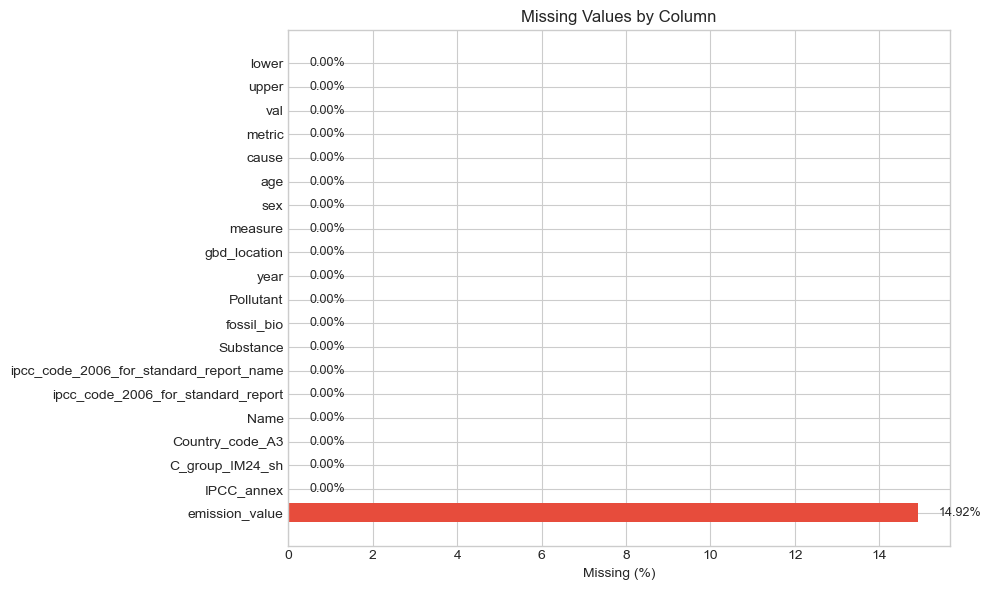

In [32]:
# Missing values analysis
null_counts = combined2.null_count()
total_rows = combined2.shape[0]

missing_df = pl.DataFrame({
    'column': null_counts.columns,
    'missing': [null_counts[col][0] for col in null_counts.columns],
}).with_columns(
    (pl.col('missing') / total_rows * 100).alias('missing_pct')
).sort('missing_pct', descending=True)

print("Missing Values Summary:")
print(missing_df)

# Visualize missing values
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#e74c3c' if x > 0 else '#2ecc71' for x in missing_df['missing_pct']]
bars = ax.barh(missing_df['column'], missing_df['missing_pct'], color=colors)
ax.set_xlabel('Missing (%)')
ax.set_title('Missing Values by Column')
ax.axvline(x=0, color='black', linewidth=0.5)
for i, (bar, pct) in enumerate(zip(bars, missing_df['missing_pct'])):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{pct:.2f}%', va='center', fontsize=9)
plt.tight_layout()
plt.show()

### 2.3 Descriptive Statistics

In [33]:
# Descriptive statistics for numerical columns
numeric_cols = ['emission_value', 'val', 'upper', 'lower']
print("=" * 80)
print("DESCRIPTIVE STATISTICS FOR NUMERICAL VARIABLES")
print("=" * 80)

for col in numeric_cols:
    stats = combined2.select([
        pl.col(col).min().alias('min'),
        pl.col(col).quantile(0.25).alias('Q1'),
        pl.col(col).median().alias('median'),
        pl.col(col).mean().alias('mean'),
        pl.col(col).quantile(0.75).alias('Q3'),
        pl.col(col).max().alias('max'),
        pl.col(col).std().alias('std'),
        pl.col(col).skew().alias('skewness'),
    ])
    print(f"\n📊 {col.upper()}")
    print(stats)

DESCRIPTIVE STATISTICS FOR NUMERICAL VARIABLES

📊 EMISSION_VALUE
shape: (1, 8)
┌────────────┬───────────┬─────────┬───────────┬──────────┬──────────────┬───────────┬──────────┐
│ min        ┆ Q1        ┆ median  ┆ mean      ┆ Q3       ┆ max          ┆ std       ┆ skewness │
│ ---        ┆ ---       ┆ ---     ┆ ---       ┆ ---      ┆ ---          ┆ ---       ┆ ---      │
│ f64        ┆ f64       ┆ f64     ┆ f64       ┆ f64      ┆ f64          ┆ f64       ┆ f64      │
╞════════════╪═══════════╪═════════╪═══════════╪══════════╪══════════════╪═══════════╪══════════╡
│ 1.8000e-12 ┆ 0.0041475 ┆ 0.09934 ┆ 26.836913 ┆ 1.673897 ┆ 52703.062825 ┆ 415.24375 ┆ 60.71088 │
└────────────┴───────────┴─────────┴───────────┴──────────┴──────────────┴───────────┴──────────┘

📊 EMISSION_VALUE
shape: (1, 8)
┌────────────┬───────────┬─────────┬───────────┬──────────┬──────────────┬───────────┬──────────┐
│ min        ┆ Q1        ┆ median  ┆ mean      ┆ Q3       ┆ max          ┆ std       ┆ skewness │
│ ---  

### 2.4 Distributions

/var/folders/v7/vfpcnz_17cl613m8n8f3_6z40000gn/T/ipykernel_89942/811460051.py:17: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/v7/vfpcnz_17cl613m8n8f3_6z40000gn/T/ipykernel_89942/811460051.py:17: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/malcolm/.miniconda3/envs/nf21_respiratory_diseases/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/malcolm/.miniconda3/envs/nf21_respiratory_diseases/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/malcolm/.miniconda3/envs/nf21_respiratory_diseases/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s

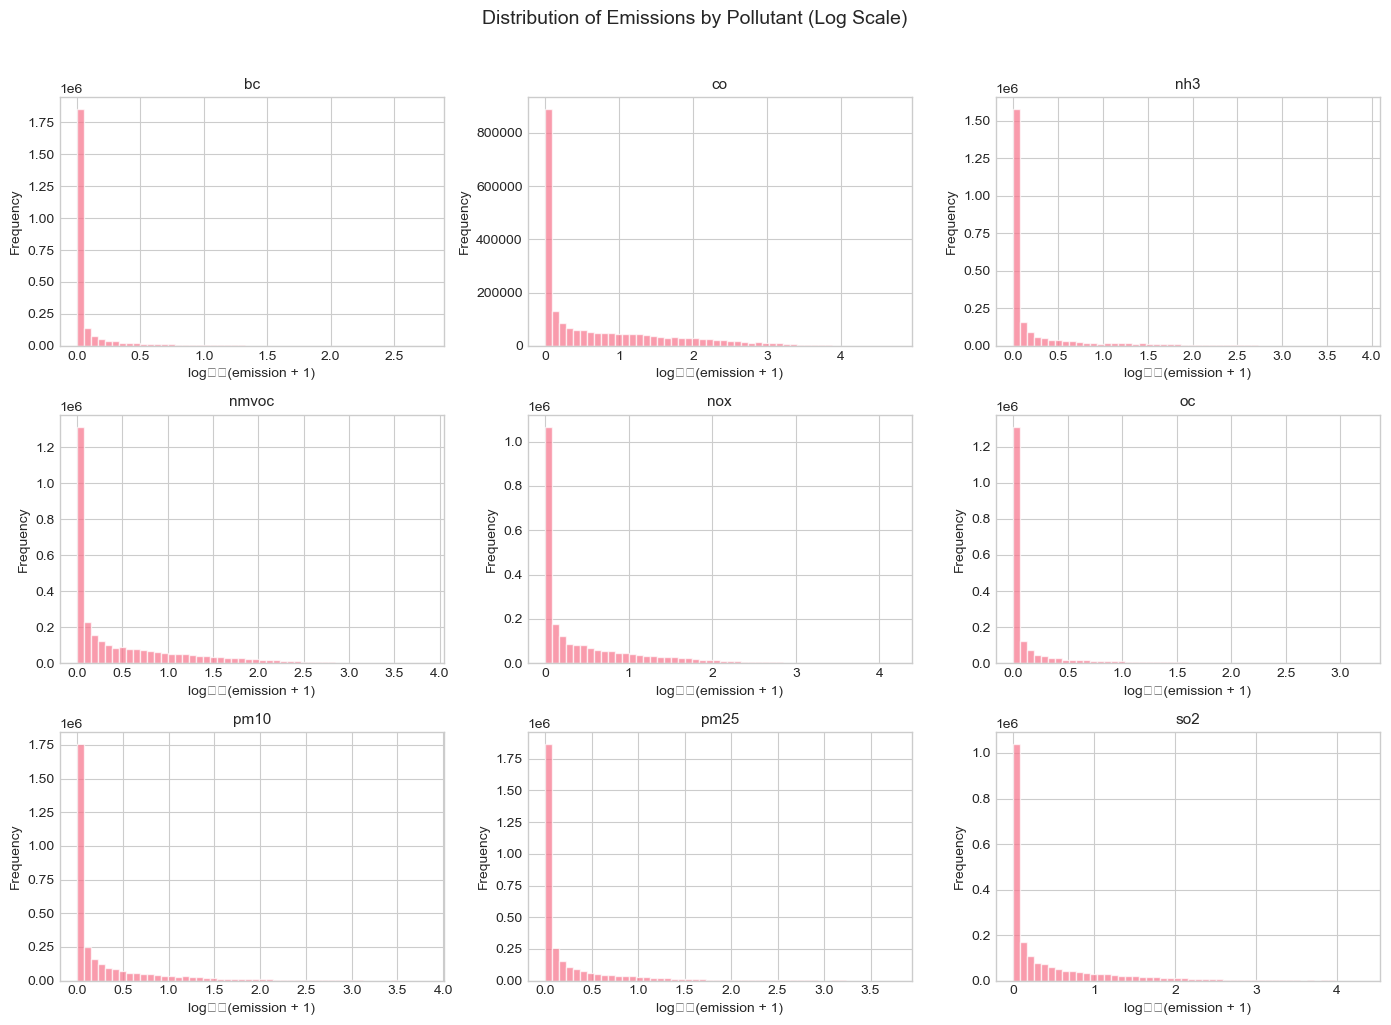

In [34]:
# Distribution of emissions by pollutant
fig, axes = plt.subplots(3, 3, figsize=(14, 10))
axes = axes.flatten()

pollutants = combined2['Pollutant'].unique().sort().to_list()

for i, pollutant in enumerate(pollutants):
    data = combined2.filter(pl.col('Pollutant') == pollutant)['emission_value'].to_numpy()
    # Use log scale due to wide range
    data_positive = data[data > 0]
    axes[i].hist(np.log10(data_positive + 1), bins=50, edgecolor='white', alpha=0.7)
    axes[i].set_title(f'{pollutant}', fontsize=11)
    axes[i].set_xlabel('log₁₀(emission + 1)')
    axes[i].set_ylabel('Frequency')

plt.suptitle('Distribution of Emissions by Pollutant (Log Scale)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

/var/folders/v7/vfpcnz_17cl613m8n8f3_6z40000gn/T/ipykernel_89942/3749756381.py:23: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/v7/vfpcnz_17cl613m8n8f3_6z40000gn/T/ipykernel_89942/3749756381.py:23: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()


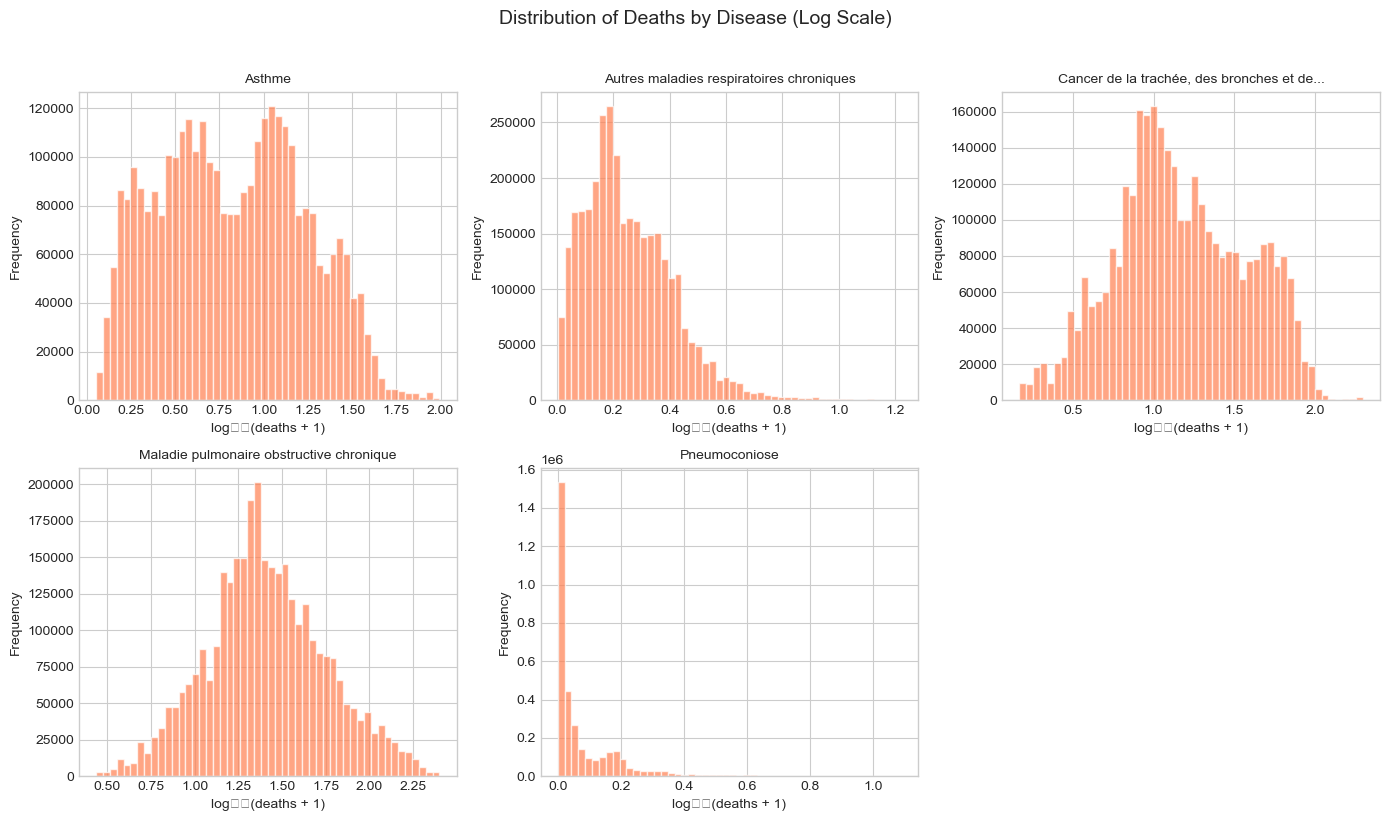

In [35]:
# Distribution of health outcomes by disease (Deaths only - "Décès" in French)
deaths_data = combined2.filter(pl.col('measure') == 'Décès')

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

diseases = deaths_data['cause'].unique().sort().to_list()

for i, disease in enumerate(diseases):
    data = deaths_data.filter(pl.col('cause') == disease)['val'].to_numpy()
    data_positive = data[data > 0]
    if len(data_positive) > 0:
        axes[i].hist(np.log10(data_positive + 1), bins=50, edgecolor='white', alpha=0.7, color='coral')
        axes[i].set_title(f'{disease[:40]}...', fontsize=10) if len(disease) > 40 else axes[i].set_title(disease, fontsize=10)
        axes[i].set_xlabel('log₁₀(deaths + 1)')
        axes[i].set_ylabel('Frequency')

# Hide empty subplot if less than 6 diseases
for j in range(len(diseases), 6):
    axes[j].axis('off')

plt.suptitle('Distribution of Deaths by Disease (Log Scale)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### 2.5 Temporal Trends

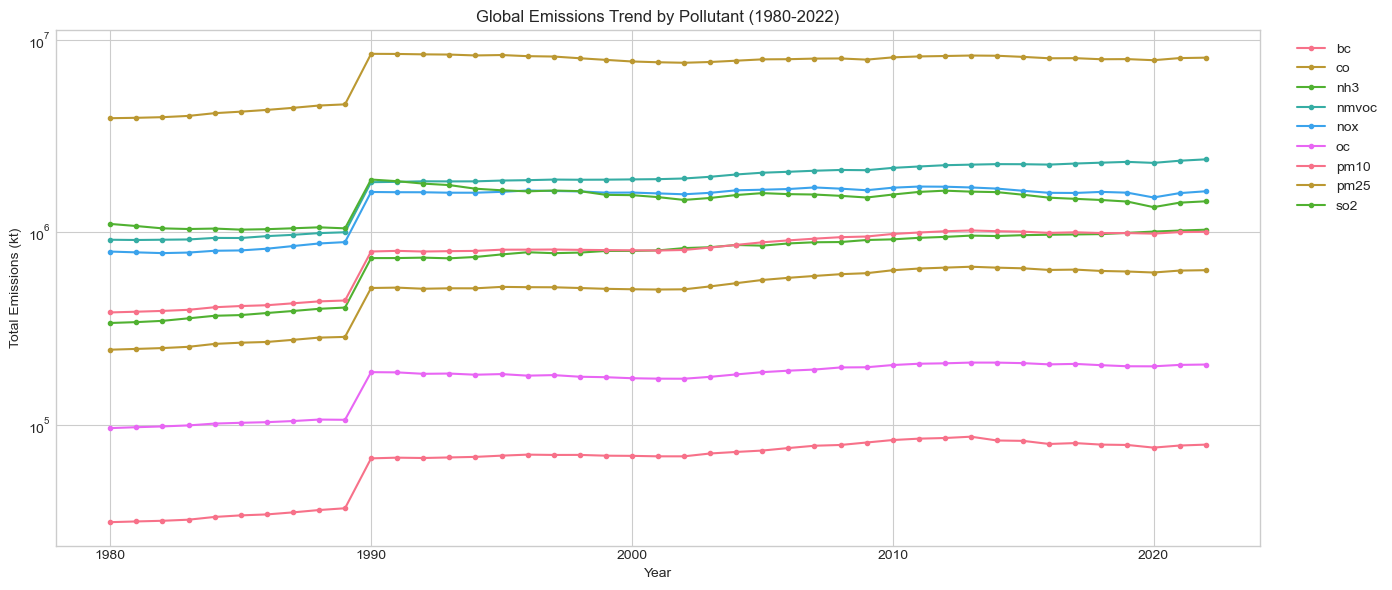

In [36]:
# Global emissions trend over time (aggregate by year and pollutant)
emissions_by_year = (
    combined2
    .group_by(['year', 'Pollutant'])
    .agg(pl.col('emission_value').sum().alias('total_emission'))
    .sort('year')
)

fig, ax = plt.subplots(figsize=(14, 6))

for pollutant in pollutants:
    data = emissions_by_year.filter(pl.col('Pollutant') == pollutant)
    ax.plot(data['year'], data['total_emission'], marker='o', markersize=3, label=pollutant, linewidth=1.5)

ax.set_xlabel('Year')
ax.set_ylabel('Total Emissions (kt)')
ax.set_title('Global Emissions Trend by Pollutant (1980-2022)')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

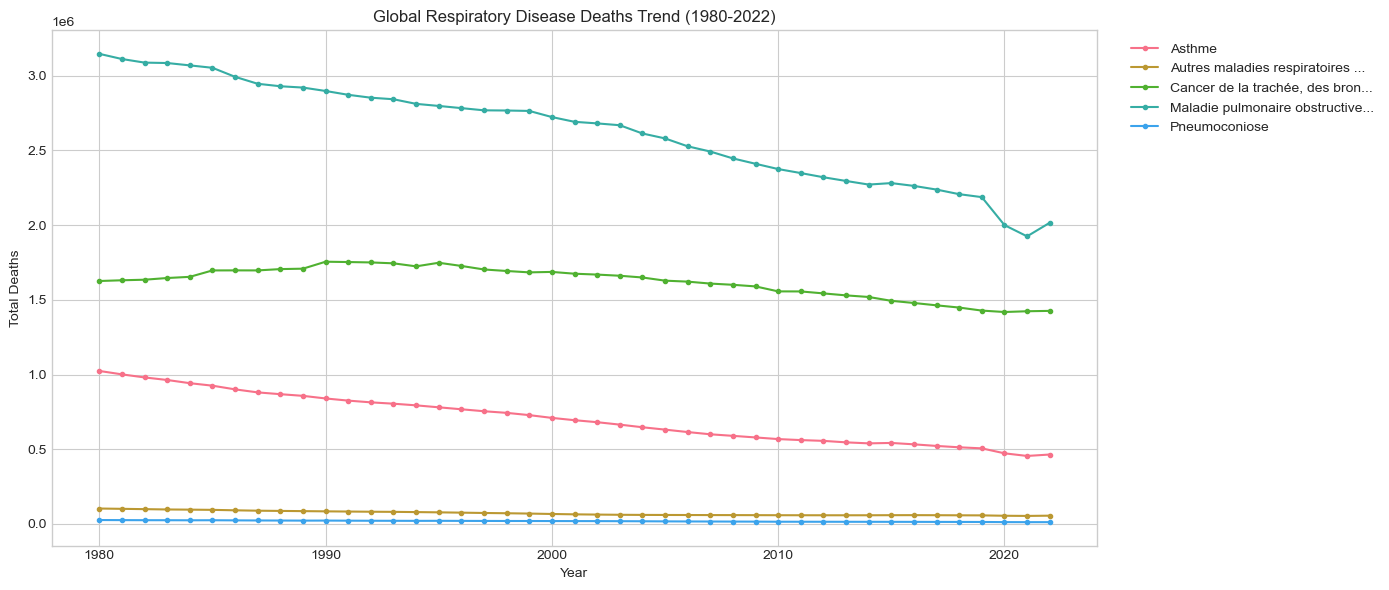

In [37]:
# Global deaths trend over time by disease
# Note: Age is already normalized ("Normalisé selon l'âge"), and there's no sex column distinct values other than what we have
deaths_by_year = (
    combined2
    .filter(pl.col('measure') == 'Décès')
    .group_by(['year', 'cause'])
    .agg(pl.col('val').sum().alias('total_deaths'))
    .sort('year')
)

fig, ax = plt.subplots(figsize=(14, 6))

for disease in diseases:
    data = deaths_by_year.filter(pl.col('cause') == disease)
    label = disease[:30] + '...' if len(disease) > 30 else disease
    ax.plot(data['year'], data['total_deaths'], marker='o', markersize=3, label=label, linewidth=1.5)

ax.set_xlabel('Year')
ax.set_ylabel('Total Deaths')
ax.set_title('Global Respiratory Disease Deaths Trend (1980-2022)')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
plt.tight_layout()
plt.show()

### 2.6 Top Countries Analysis

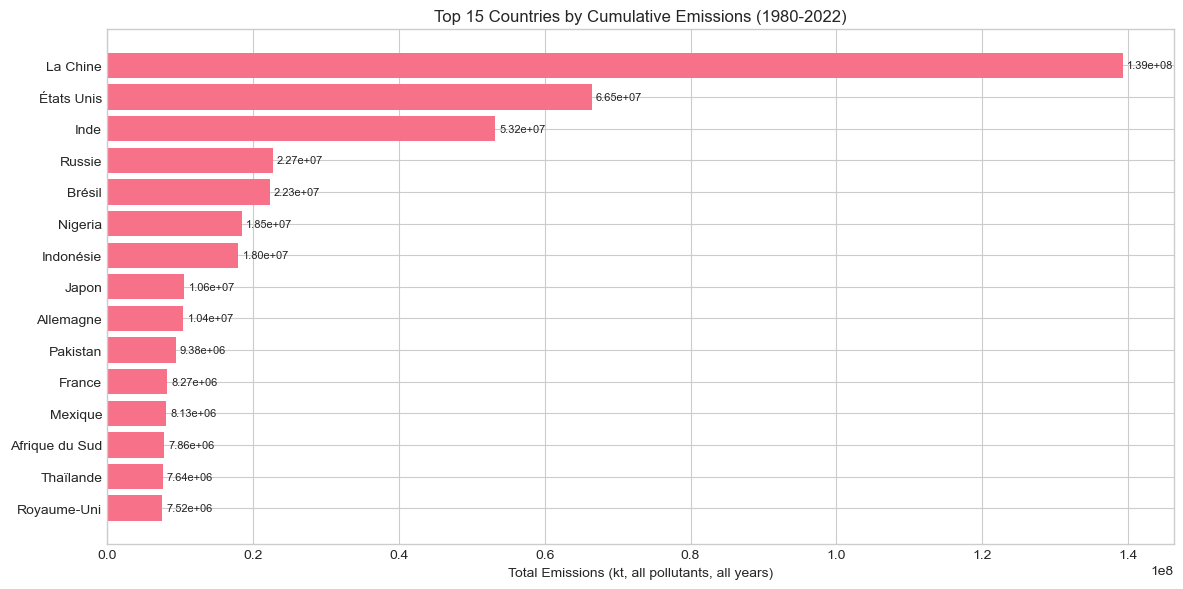

In [38]:
# Top 15 countries by total emissions
top_emitters = (
    combined2
    .group_by('gbd_location')
    .agg(pl.col('emission_value').sum().alias('total_emission'))
    .sort('total_emission', descending=True)
    .head(15)
)

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(top_emitters['gbd_location'][::-1], top_emitters['total_emission'][::-1])
ax.set_xlabel('Total Emissions (kt, all pollutants, all years)')
ax.set_title('Top 15 Countries by Cumulative Emissions (1980-2022)')
ax.bar_label(bars, fmt='%.2e', padding=3, fontsize=8)
plt.tight_layout()
plt.show()

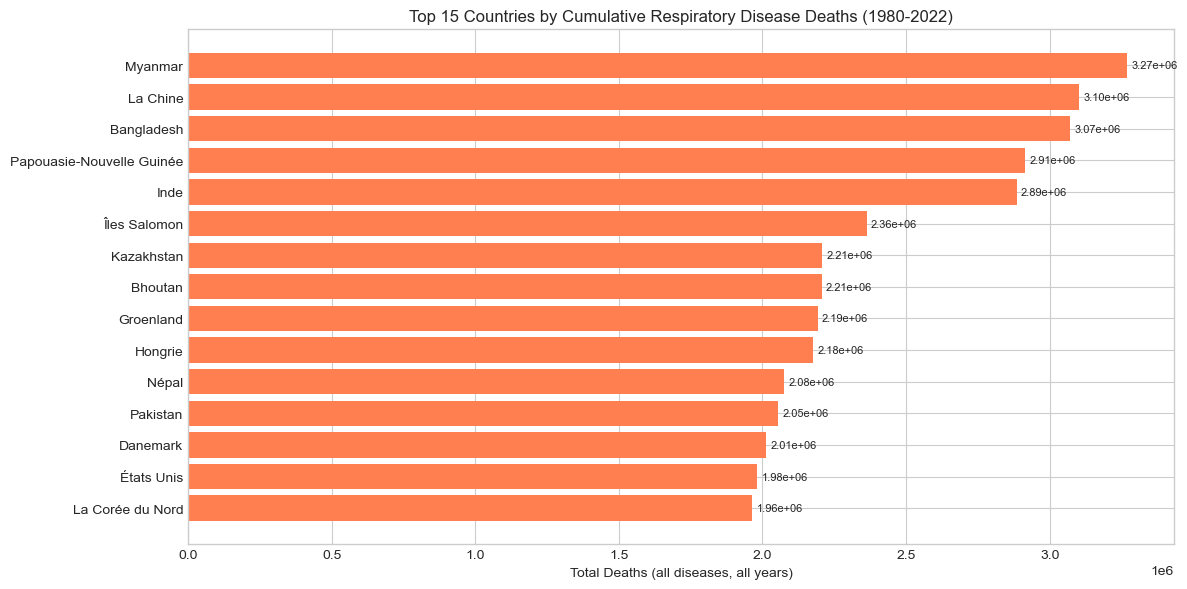

In [39]:
# Top 15 countries by respiratory disease deaths
top_deaths = (
    combined2
    .filter(pl.col('measure') == 'Décès')
    .group_by('gbd_location')
    .agg(pl.col('val').sum().alias('total_deaths'))
    .sort('total_deaths', descending=True)
    .head(15)
)

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(top_deaths['gbd_location'][::-1], top_deaths['total_deaths'][::-1], color='coral')
ax.set_xlabel('Total Deaths (all diseases, all years)')
ax.set_title('Top 15 Countries by Cumulative Respiratory Disease Deaths (1980-2022)')
ax.bar_label(bars, fmt='%.2e', padding=3, fontsize=8)
plt.tight_layout()
plt.show()

### 2.7 Sector Analysis

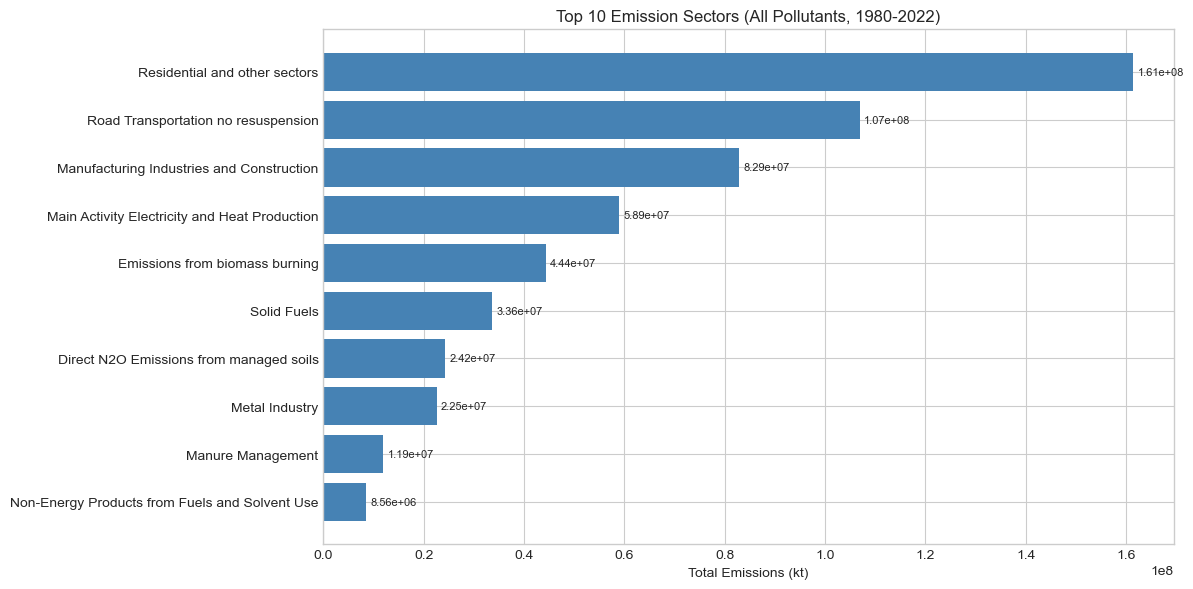

In [40]:
# Top 10 sectors by emissions
top_sectors = (
    combined2
    .group_by('ipcc_code_2006_for_standard_report_name')
    .agg(pl.col('emission_value').sum().alias('total_emission'))
    .sort('total_emission', descending=True)
    .head(10)
)

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(top_sectors['ipcc_code_2006_for_standard_report_name'][::-1], top_sectors['total_emission'][::-1], color='steelblue')
ax.set_xlabel('Total Emissions (kt)')
ax.set_title('Top 10 Emission Sectors (All Pollutants, 1980-2022)')
ax.bar_label(bars, fmt='%.2e', padding=3, fontsize=8)
plt.tight_layout()
plt.show()

/var/folders/v7/vfpcnz_17cl613m8n8f3_6z40000gn/T/ipykernel_89942/2006735527.py:26: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/v7/vfpcnz_17cl613m8n8f3_6z40000gn/T/ipykernel_89942/2006735527.py:26: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/malcolm/.miniconda3/envs/nf21_respiratory_diseases/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/malcolm/.miniconda3/envs/nf21_respiratory_diseases/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


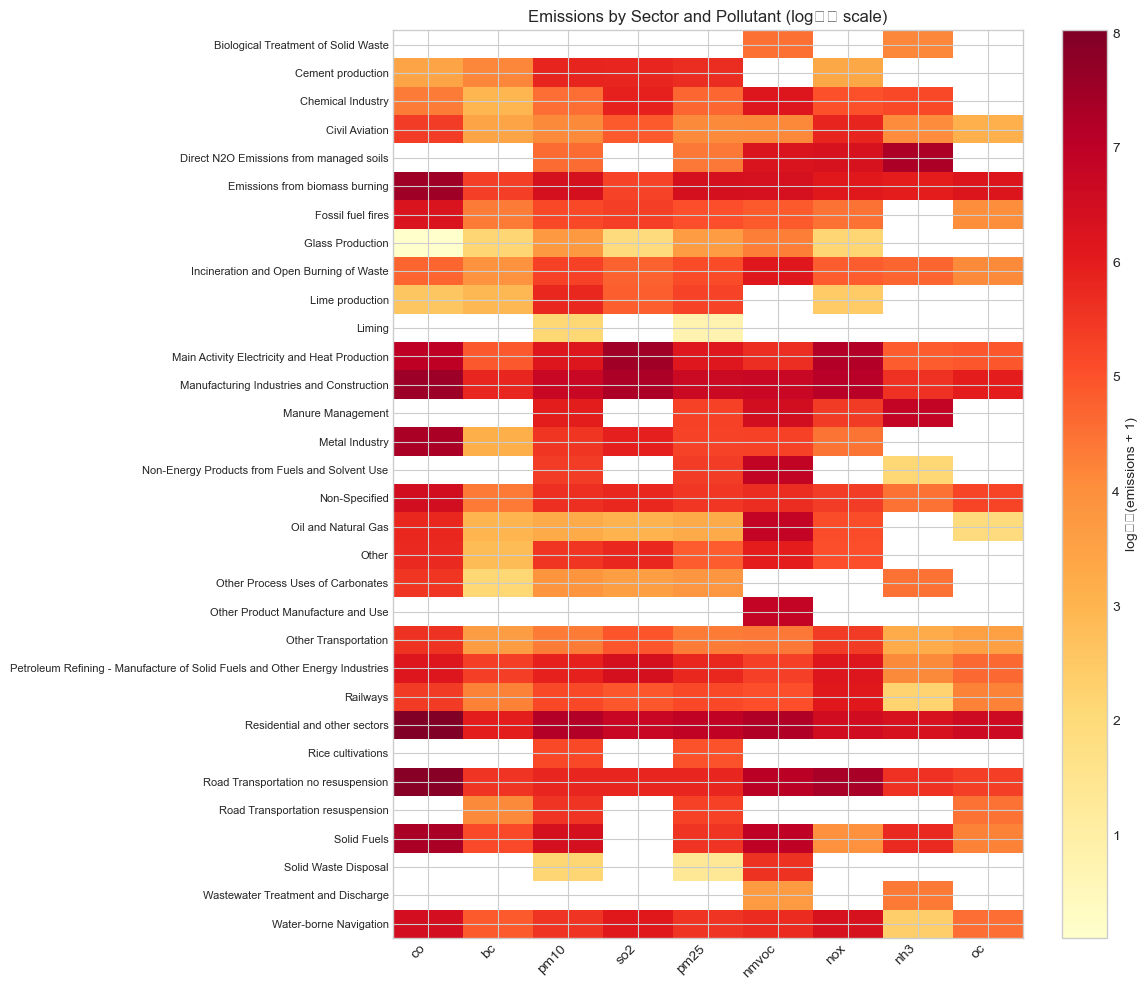

In [41]:
# Emissions by sector and pollutant (heatmap)
sector_pollutant = (
    combined2
    .group_by(['ipcc_code_2006_for_standard_report_name', 'Pollutant'])
    .agg(pl.col('emission_value').sum().alias('total_emission'))
    .pivot(on='Pollutant', index='ipcc_code_2006_for_standard_report_name', values='total_emission')
    .sort('ipcc_code_2006_for_standard_report_name')
)

# Convert to numpy for heatmap
sector_names = sector_pollutant['ipcc_code_2006_for_standard_report_name'].to_list()
pollutant_cols = [c for c in sector_pollutant.columns if c != 'ipcc_code_2006_for_standard_report_name']
heatmap_data = sector_pollutant.select(pollutant_cols).to_numpy()

# Log transform for better visualization
heatmap_data_log = np.log10(heatmap_data + 1)

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(heatmap_data_log, cmap='YlOrRd', aspect='auto')
ax.set_xticks(range(len(pollutant_cols)))
ax.set_xticklabels(pollutant_cols, rotation=45, ha='right')
ax.set_yticks(range(len(sector_names)))
ax.set_yticklabels(sector_names, fontsize=8)
ax.set_title('Emissions by Sector and Pollutant (log₁₀ scale)')
plt.colorbar(im, ax=ax, label='log₁₀(emissions + 1)')
plt.tight_layout()
plt.show()

### 2.8 Correlation Analysis: Pollutants vs Disease Deaths

To properly analyze correlations, we need to aggregate the data to avoid the cartesian product effect. 
We'll aggregate by country-year to get:
- Total emissions per pollutant (summed across all sectors)
- Total deaths per disease (filtered for both sexes, all ages)

In [17]:
# Step 1: Aggregate emissions by country, year, pollutant
# Include Country_code_A3 (ISO code) for mapping later
emissions_agg = (
    combined2
    .group_by(['gbd_location', 'Country_code_A3', 'year', 'Pollutant'])
    .agg(pl.col('emission_value').sum().alias('total_emission'))
    .pivot(on='Pollutant', index=['gbd_location', 'Country_code_A3', 'year'], values='total_emission')
)

print(f"Emissions aggregated: {emissions_agg.shape}")
print(emissions_agg.head())

Emissions aggregated: (8514, 12)
shape: (5, 12)
┌────────────┬────────────┬──────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ gbd_locati ┆ Country_co ┆ year ┆ pm25       ┆ … ┆ nh3        ┆ oc        ┆ pm10      ┆ bc        │
│ on         ┆ de_A3      ┆ ---  ┆ ---        ┆   ┆ ---        ┆ ---       ┆ ---       ┆ ---       │
│ ---        ┆ ---        ┆ i32  ┆ f64        ┆   ┆ f64        ┆ f64       ┆ f64       ┆ f64       │
│ str        ┆ str        ┆      ┆            ┆   ┆            ┆           ┆           ┆           │
╞════════════╪════════════╪══════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ Norvège    ┆ NOR        ┆ 2020 ┆ 607.997653 ┆ … ┆ 963.37679  ┆ 100.48868 ┆ 732.38602 ┆ 72.48008  │
│            ┆            ┆      ┆            ┆   ┆            ┆ 9         ┆ 3         ┆           │
│ La Corée   ┆ PRK        ┆ 1985 ┆ 2633.33203 ┆ … ┆ 1862.42384 ┆ 522.26339 ┆ 3698.3710 ┆ 181.34871 │
│ du Nord    ┆            ┆      ┆ 8       

In [18]:
# Step 2: Aggregate deaths by country, year, disease (Décès = Deaths in French)
# Include Country_code_A3 (ISO code) for mapping later
deaths_agg = (
    combined2
    .filter(pl.col('measure') == 'Décès')
    .group_by(['gbd_location', 'Country_code_A3', 'year', 'cause'])
    .agg(pl.col('val').sum().alias('total_deaths'))
    .pivot(on='cause', index=['gbd_location', 'Country_code_A3', 'year'], values='total_deaths')
)

print(f"Deaths aggregated: {deaths_agg.shape}")
print(deaths_agg.head())

Deaths aggregated: (8514, 8)
shape: (5, 8)
┌─────────────┬────────────┬──────┬────────────┬────────────┬────────────┬────────────┬────────────┐
│ gbd_locatio ┆ Country_co ┆ year ┆ Maladie    ┆ Asthme     ┆ Cancer de  ┆ Pneumoconi ┆ Autres     │
│ n           ┆ de_A3      ┆ ---  ┆ pulmonaire ┆ ---        ┆ la         ┆ ose        ┆ maladies   │
│ ---         ┆ ---        ┆ i32  ┆ obstructiv ┆ f64        ┆ trachée,   ┆ ---        ┆ respiratoi │
│ str         ┆ str        ┆      ┆ e…         ┆            ┆ des bron…  ┆ f64        ┆ res …      │
│             ┆            ┆      ┆ ---        ┆            ┆ ---        ┆            ┆ ---        │
│             ┆            ┆      ┆ f64        ┆            ┆ f64        ┆            ┆ f64        │
╞═════════════╪════════════╪══════╪════════════╪════════════╪════════════╪════════════╪════════════╡
│ Gabon       ┆ GAB        ┆ 1985 ┆ 16084.2368 ┆ 7145.43018 ┆ 2217.17742 ┆ 112.481299 ┆ 350.376617 │
│             ┆            ┆      ┆ 28         ┆

In [19]:
# Step 3: Join emissions and deaths on country + year
correlation_data = emissions_agg.join(
    deaths_agg,
    on=['gbd_location', 'Country_code_A3', 'year'],
    how='inner'
)

print(f"Joined data for correlation: {correlation_data.shape}")
print(f"Countries: {correlation_data['gbd_location'].n_unique()}")
print(f"Years: {correlation_data['year'].n_unique()}")
print(f"Countries with ISO codes: {correlation_data['Country_code_A3'].n_unique()}")
print(correlation_data.head())

Joined data for correlation: (8514, 17)
Countries: 198
Years: 43
Countries with ISO codes: 198
shape: (5, 17)
┌────────────┬────────────┬──────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ gbd_locati ┆ Country_co ┆ year ┆ pm25       ┆ … ┆ Asthme     ┆ Cancer de ┆ Pneumocon ┆ Autres    │
│ on         ┆ de_A3      ┆ ---  ┆ ---        ┆   ┆ ---        ┆ la        ┆ iose      ┆ maladies  │
│ ---        ┆ ---        ┆ i32  ┆ f64        ┆   ┆ f64        ┆ trachée,  ┆ ---       ┆ respirato │
│ str        ┆ str        ┆      ┆            ┆   ┆            ┆ des bron… ┆ f64       ┆ ires …    │
│            ┆            ┆      ┆            ┆   ┆            ┆ ---       ┆           ┆ ---       │
│            ┆            ┆      ┆            ┆   ┆            ┆ f64       ┆           ┆ f64       │
╞════════════╪════════════╪══════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ Gabon      ┆ GAB        ┆ 1985 ┆ 103.373688 ┆ … ┆ 7145.43018 ┆ 2217.1774 ┆ 112.4

In [20]:
# Step 4: Calculate correlation matrix between pollutants and disease deaths
# Get column names for pollutants and diseases
pollutant_cols = [c for c in emissions_agg.columns if c not in ['gbd_location', 'Country_code_A3', 'year']]
disease_cols = [c for c in deaths_agg.columns if c not in ['gbd_location', 'Country_code_A3', 'year']]

print(f"Pollutants: {pollutant_cols}")
print(f"Diseases: {disease_cols}")

# Create correlation matrix (Pollutants vs Diseases)
# Convert to pandas for correlation calculation
corr_df = correlation_data.select(pollutant_cols + disease_cols).to_pandas()

# Full correlation matrix
full_corr = corr_df.corr()

# Extract just Pollutants vs Diseases
pollutant_disease_corr = full_corr.loc[pollutant_cols, disease_cols]

print("\n" + "=" * 60)
print("CORRELATION MATRIX: Pollutants vs Respiratory Disease Deaths")
print("=" * 60)
print(pollutant_disease_corr.round(3))

Pollutants: ['pm25', 'co', 'so2', 'nox', 'nmvoc', 'nh3', 'oc', 'pm10', 'bc']
Diseases: ['Maladie pulmonaire obstructive chronique', 'Asthme', 'Cancer de la trachée, des bronches et des poumons', 'Pneumoconiose', 'Autres maladies respiratoires chroniques']

CORRELATION MATRIX: Pollutants vs Respiratory Disease Deaths
       Maladie pulmonaire obstructive chronique  Asthme  \
pm25                                      0.332   0.003   
co                                        0.316  -0.014   
so2                                       0.275  -0.059   
nox                                       0.230  -0.077   
nmvoc                                     0.294  -0.026   
nh3                                       0.367  -0.009   
oc                                        0.370   0.038   
pm10                                      0.338   0.020   
bc                                        0.340   0.016   

       Cancer de la trachée, des bronches et des poumons  Pneumoconiose  \
pm25            

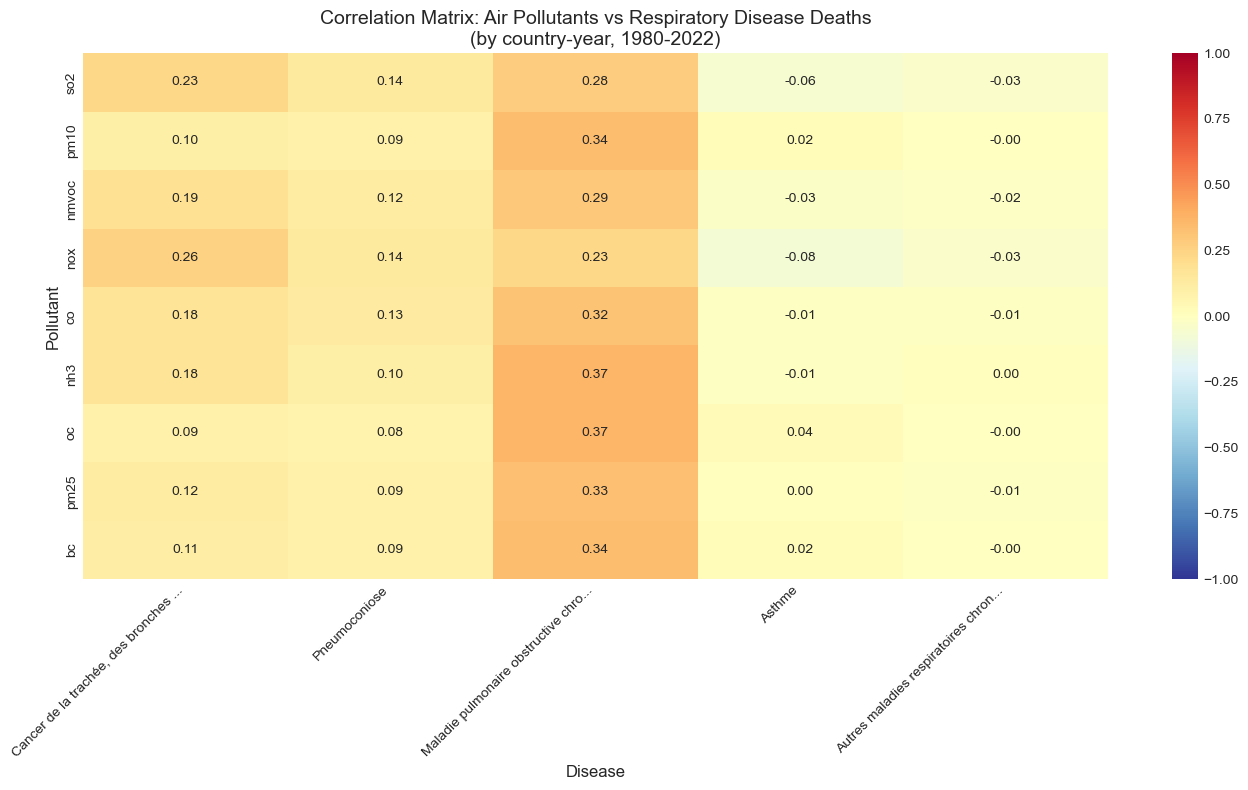

In [46]:
# Visualize the correlation matrix (Pollutants vs Diseases)
fig, ax = plt.subplots(figsize=(14, 8))

# Create shortened disease names for display
disease_labels = [d[:35] + '...' if len(d) > 35 else d for d in disease_cols]

sns.heatmap(
    pollutant_disease_corr.values,
    xticklabels=disease_labels,
    yticklabels=pollutant_cols,
    annot=True,
    fmt='.2f',
    cmap='RdYlBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    ax=ax,
    annot_kws={'size': 10}
)

ax.set_title('Correlation Matrix: Air Pollutants vs Respiratory Disease Deaths\n(by country-year, 1980-2022)', fontsize=14)
ax.set_xlabel('Disease', fontsize=12)
ax.set_ylabel('Pollutant', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

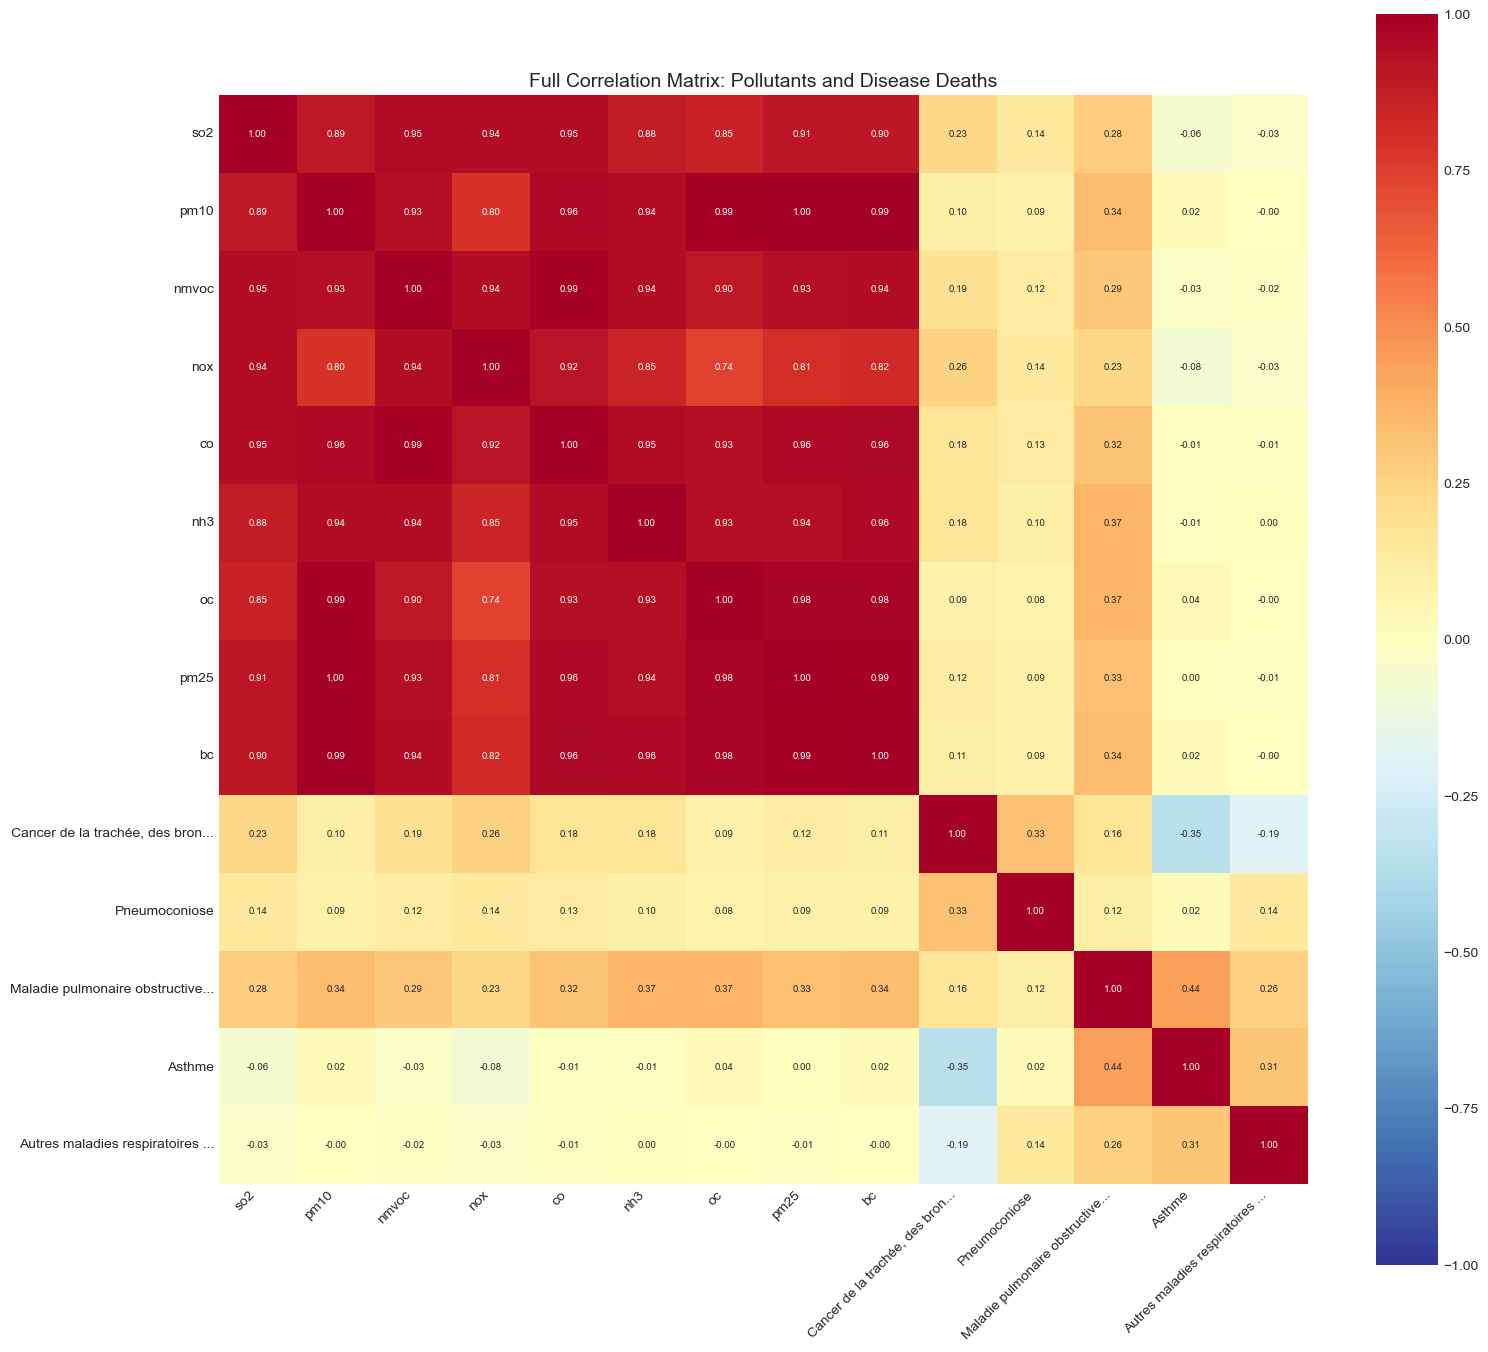

In [47]:
# Full correlation matrix including pollutant-pollutant and disease-disease correlations
fig, ax = plt.subplots(figsize=(16, 14))

# Create shortened labels
all_labels = pollutant_cols + [d[:30] + '...' if len(d) > 30 else d for d in disease_cols]

sns.heatmap(
    full_corr.values,
    xticklabels=all_labels,
    yticklabels=all_labels,
    annot=True,
    fmt='.2f',
    cmap='RdYlBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    ax=ax,
    annot_kws={'size': 7},
    square=True
)

ax.set_title('Full Correlation Matrix: Pollutants and Disease Deaths', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 2.9 Scatter Plots: Key Pollutant-Disease Relationships

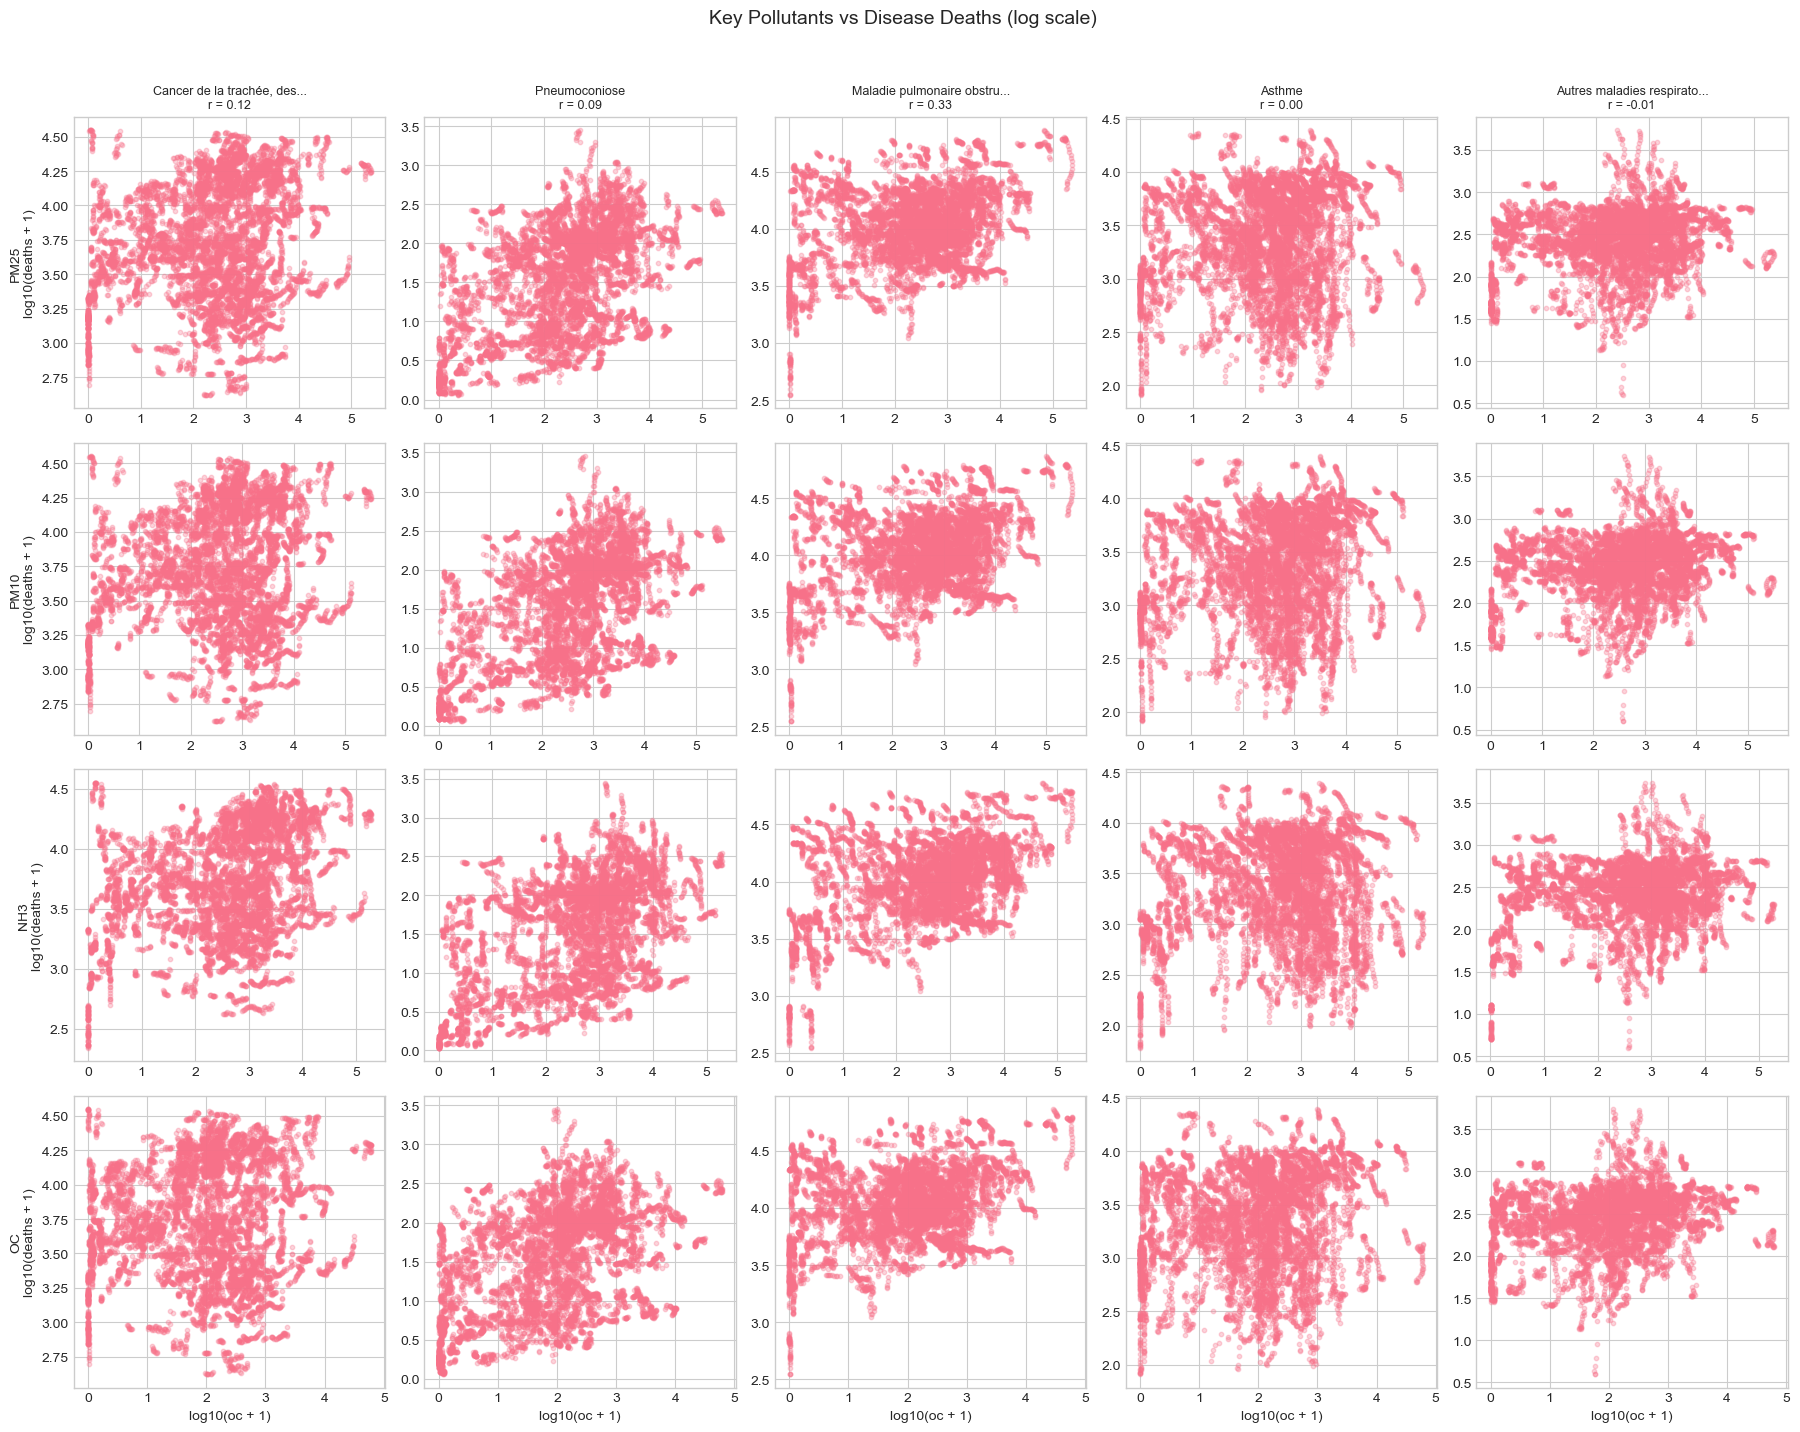

In [52]:
# Scatter plots for pm25, pm10, nh3, and oc vs all diseases (key pollutants)
fig, axes = plt.subplots(4, len(disease_cols), figsize=(18, 14))

key_pollutants = ['pm25', 'pm10', 'nh3', 'oc']
corr_data_pd = correlation_data.to_pandas()

for i, pollutant in enumerate(key_pollutants):
    for j, disease in enumerate(disease_cols):
        ax = axes[i, j]
        x = corr_data_pd[pollutant]
        y = corr_data_pd[disease]
        
        # Use log scale for better visualization
        ax.scatter(np.log10(x + 1), np.log10(y + 1), alpha=0.3, s=10)
        ax.set_xlabel(f'log10({pollutant} + 1)') if i == 3 else ax.set_xlabel('')
        ax.set_ylabel(f'log10(deaths + 1)') if j == 0 else None
        
        # Shortened title
        disease_short = disease[:25] + '...' if len(disease) > 25 else disease
        corr_val = pollutant_disease_corr.loc[pollutant, disease]
        ax.set_title(f'{disease_short}\nr = {corr_val:.2f}', fontsize=9) if i == 0 else None
        
        # Add pollutant label on y-axis for first column
        if j == 0:
            ax.set_ylabel(f'{pollutant.upper()}\nlog10(deaths + 1)', fontsize=10)

plt.suptitle('Key Pollutants vs Disease Deaths (log scale)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### 2.10 Geographic Distribution: World Maps

In [12]:
# Note: Install these packages in your nf21_respiratory_diseases environment:
# conda install plotly kaleido nbformat -c conda-forge
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [21]:
# Aggregate data by country (average over all years)
# Use Country_code_A3 directly from the dataset (no manual mapping needed!)
country_avg = correlation_data.group_by(['gbd_location', 'Country_code_A3']).agg([
    pl.col('pm25').mean().alias('pm25_avg'),
    pl.col('pm10').mean().alias('pm10_avg'),
    pl.col('nh3').mean().alias('nh3_avg'),
    pl.col('oc').mean().alias('oc_avg'),
    pl.col('Cancer de la trachée, des bronches et des poumons').mean().alias('cancer_avg'),
    pl.col('Maladie pulmonaire obstructive chronique').mean().alias('copd_avg'),
])

# Convert to pandas
country_avg_pd = country_avg.to_pandas()

# Log transform for better color scale visualization
country_avg_pd['pm25_log'] = np.log10(country_avg_pd['pm25_avg'] + 1)
country_avg_pd['pm10_log'] = np.log10(country_avg_pd['pm10_avg'] + 1)
country_avg_pd['nh3_log'] = np.log10(country_avg_pd['nh3_avg'] + 1)
country_avg_pd['oc_log'] = np.log10(country_avg_pd['oc_avg'] + 1)
country_avg_pd['cancer_log'] = np.log10(country_avg_pd['cancer_avg'] + 1)
country_avg_pd['copd_log'] = np.log10(country_avg_pd['copd_avg'] + 1)

# Check coverage
valid_iso = country_avg_pd['Country_code_A3'].notna() & (country_avg_pd['Country_code_A3'] != '')
print(f"Countries with valid ISO codes: {valid_iso.sum()} / {len(country_avg_pd)}")
print(f"\nSample data:")
print(country_avg_pd[['gbd_location', 'Country_code_A3', 'pm25_avg', 'cancer_avg']].head(10))

Countries with valid ISO codes: 198 / 198

Sample data:
             gbd_location Country_code_A3     pm25_avg    cancer_avg
0  Îles Mariannes du Nord             MNP          NaN    428.272725
1                   Japon             JPN  4402.157116  14146.441190
2                   Syrie             SYR   252.450759   4322.768524
3                  Suisse             CHE   358.354402  16185.035724
4               Nicaragua             NIC   337.045640   2527.068867
5                  Brunei             BRN    11.255035   9288.132125
6                    Iran             IRN  1263.454957   5575.217222
7                   Ghana             GHA  1079.880446   2726.547656
8                 Estonie             EST   135.844617  19002.482577
9            Kirghizistan             KGZ   139.784224   7271.490840


In [22]:
# World maps for 4 pollutants (PM2.5, PM10, NH3, OC)
# Using Country_code_A3 directly from EDGAR dataset
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=['PM2.5 Emissions', 'PM10 Emissions', 'NH3 Emissions', 'OC Emissions'],
    specs=[[{"type": "choropleth"}, {"type": "choropleth"}],
           [{"type": "choropleth"}, {"type": "choropleth"}]],
    horizontal_spacing=0.02,
    vertical_spacing=0.05
)

pollutant_data = [
    ('pm25_log', 'pm25_avg', 'Oranges', 1, 1),
    ('pm10_log', 'pm10_avg', 'Reds', 1, 2),
    ('nh3_log', 'nh3_avg', 'Greens', 2, 1),
    ('oc_log', 'oc_avg', 'Purples', 2, 2),
]

for log_col, avg_col, colorscale, row, c in pollutant_data:
    fig.add_trace(
        go.Choropleth(
            locations=country_avg_pd['Country_code_A3'],
            z=country_avg_pd[log_col],
            text=country_avg_pd['gbd_location'],
            colorscale=colorscale,
            showscale=True,
            colorbar=dict(title='log₁₀(kt)', len=0.4),
            marker_line_width=0.5,
            hovertemplate='<b>%{text}</b><br>Emissions: %{customdata:,.0f} kt<extra></extra>',
            customdata=country_avg_pd[avg_col],
        ),
        row=row, col=c
    )

fig.update_geos(
    showcoastlines=True,
    coastlinecolor="Gray",
    showland=True,
    landcolor="lightgray",
    showocean=True,
    oceancolor="aliceblue",
    projection_type="natural earth"
)

fig.update_layout(
    title_text='Average Pollutant Emissions by Country (1980-2022, log scale)',
    height=700,
    margin=dict(l=0, r=0, t=50, b=0)
)

fig.show()

In [23]:
# World maps for the 2 most correlated diseases
# Cancer de la trachée, des bronches et des poumons
# Maladie pulmonaire obstructive chronique

disease_map_info = [
    ('cancer_avg', 'cancer_log', 'Cancer de la trachée'),
    ('copd_avg', 'copd_log', 'MPOC (Maladie pulmonaire obstructive chronique)')
]

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=[label for _, _, label in disease_map_info],
    specs=[[{'type': 'choropleth'}, {'type': 'choropleth'}]],
    horizontal_spacing=0.02
)

for i, (avg_col, log_col, label) in enumerate(disease_map_info):
    choropleth = go.Choropleth(
        locations=country_avg_pd['Country_code_A3'],
        z=country_avg_pd[log_col],
        text=country_avg_pd['gbd_location'],
        colorscale='Reds',
        showscale=(i == len(disease_map_info) - 1),
        colorbar=dict(
            title='Log₁₀ Deaths',
            x=1.02
        ) if i == len(disease_map_info) - 1 else None,
        hovertemplate='<b>%{text}</b><br>' + label + ': %{customdata:,.0f} deaths<extra></extra>',
        customdata=country_avg_pd[avg_col]
    )
    fig.add_trace(choropleth, row=1, col=i+1)

fig.update_geos(
    showframe=False,
    showcoastlines=True,
    projection_type='natural earth'
)

fig.update_layout(
    title_text='Geographic Distribution of Respiratory Disease Deaths<br>(Average annual deaths per country, log scale)',
    height=450,
    margin=dict(l=10, r=10, t=80, b=10)
)

fig.show()

### 2.10 Data Quality Assessment Summary

In [50]:
# Data Quality Summary
print("=" * 70)
print("DATA QUALITY ASSESSMENT SUMMARY (CRISP-DM)")
print("=" * 70)

# Completeness
missing_pct = (combined2.null_count().sum_horizontal()[0] / (combined2.shape[0] * combined2.shape[1])) * 100
print(f"\n📊 COMPLETENESS")
print(f"   Total cells: {combined2.shape[0] * combined2.shape[1]:,}")
print(f"   Missing values: {combined2.null_count().sum_horizontal()[0]:,}")
print(f"   Missing percentage: {missing_pct:.4f}%")

# Coverage
print(f"\n🌍 COVERAGE")
print(f"   Countries: {combined2['gbd_location'].n_unique()}")
print(f"   Years: {combined2['year'].min()} - {combined2['year'].max()}")
print(f"   Pollutants: {combined2['Pollutant'].n_unique()}")
print(f"   Diseases: {combined2['cause'].n_unique()}")
print(f"   Sectors: {combined2['ipcc_code_2006_for_standard_report_name'].n_unique()}")

# Data types check
print(f"\n🔧 DATA TYPES")
for col in combined2.columns:
    dtype = combined2[col].dtype
    print(f"   {col}: {dtype}")

# Outlier check for numerical columns
print(f"\n⚠️ POTENTIAL OUTLIERS (values > Q3 + 3*IQR)")
for col in ['emission_value', 'val']:
    q1 = combined2[col].quantile(0.25)
    q3 = combined2[col].quantile(0.75)
    iqr = q3 - q1
    upper_bound = q3 + 3 * iqr
    outliers = combined2.filter(pl.col(col) > upper_bound).shape[0]
    outlier_pct = outliers / combined2.shape[0] * 100
    print(f"   {col}: {outliers:,} outliers ({outlier_pct:.2f}%)")

print("\n" + "=" * 70)
print("KEY FINDINGS:")
print("=" * 70)
print("""
1. Data is highly complete with minimal missing values
2. Strong correlations exist between most pollutants (they co-occur)
3. Moderate positive correlations between pollutants and disease deaths
4. Data spans 43 years (1980-2022) with 198 countries
5. Emissions data is highly skewed (log transformation recommended)
6. Consider population normalization for per-capita analysis
""")

DATA QUALITY ASSESSMENT SUMMARY (CRISP-DM)

📊 COMPLETENESS
   Total cells: 533,339,000
   Missing values: 3,979,298
   Missing percentage: 0.7461%

🌍 COVERAGE
   Countries: 198
   Years: 1980 - 2022
   Countries: 198
   Years: 1980 - 2022
   Pollutants: 9
   Pollutants: 9
   Diseases: 5
   Diseases: 5
   Sectors: 32

🔧 DATA TYPES
   IPCC_annex: String
   C_group_IM24_sh: String
   Country_code_A3: String
   Name: String
   ipcc_code_2006_for_standard_report: String
   ipcc_code_2006_for_standard_report_name: String
   Substance: String
   fossil_bio: String
   Pollutant: String
   emission_value: Float64
   year: Int32
   gbd_location: String
   measure: String
   sex: String
   age: String
   cause: String
   metric: String
   val: Float64
   upper: Float64
   lower: Float64

⚠️ POTENTIAL OUTLIERS (values > Q3 + 3*IQR)
   Sectors: 32

🔧 DATA TYPES
   IPCC_annex: String
   C_group_IM24_sh: String
   Country_code_A3: String
   Name: String
   ipcc_code_2006_for_standard_report: String
 

### 2.11 Save Aggregated Data for Modeling

In [51]:
# Save the aggregated correlation dataset for future modeling
correlation_data.write_parquet('data/combined/correlation_ready.parquet')

print(f"Saved aggregated dataset: {correlation_data.shape[0]:,} rows × {correlation_data.shape[1]} columns")
print(f"File: data/combined/correlation_ready.parquet")
print(f"\nColumns: {correlation_data.columns}")

Saved aggregated dataset: 8,514 rows × 16 columns
File: data/combined/correlation_ready.parquet

Columns: ['gbd_location', 'year', 'so2', 'pm10', 'nmvoc', 'nox', 'co', 'nh3', 'oc', 'pm25', 'bc', 'Cancer de la trachée, des bronches et des poumons', 'Pneumoconiose', 'Maladie pulmonaire obstructive chronique', 'Asthme', 'Autres maladies respiratoires chroniques']
